## Deep Learning on CIFAR-10

*Import Libraries*

In [9]:
import time
import numpy as np
K.set_image_data_format("channels_last")

import matplotlib.pyplot as plt
#from livelossplot import PlotLossesKeras
from PIL import Image

import h5py
import pickle
import os
from keras.utils.data_utils import get_file

from scipy import stats
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectPercentile, chi2, SelectFromModel
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC, LinearSVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.cluster import MiniBatchKMeans
import cv2
sift = cv2.SIFT_create()

*Function Def*

In [2]:
def load_batch(fpath, label_key='labels'):
    f = open(fpath, 'rb')
    d = pickle.load(f, encoding='bytes')
    d_decoded = {}  # decode utf8
    for k, v in d.items():
        d_decoded[k.decode('utf8')] = v
    d = d_decoded
    f.close()
    data = d['data']
    labels = d[label_key]
    data = data.reshape(data.shape[0], 32, 32, 3)
    return data, labels

def load_cfar10_dataset():
    dirname = 'cifar-10-batches-py'
    origin = 'http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'
    path = get_file(dirname, origin=origin, untar=True)
    num_train_samples = 50000
    x_train = np.zeros((num_train_samples, 32, 32, 3), dtype='uint8')
    y_train = np.zeros((num_train_samples,), dtype='uint8')
    for i in range(1, 6):
        fpath = os.path.join(path, 'data_batch_' + str(i))
        data, labels = load_batch(fpath)
        x_train[(i - 1) * 10000: i * 10000, :, :, :] = data
        y_train[(i - 1) * 10000: i * 10000] = labels
    fpath = os.path.join(path, 'test_batch')

    x_test, y_test = load_batch(fpath)
    y_train = np.reshape(y_train, (len(y_train), 1))
    y_test = np.reshape(y_test, (len(y_test), 1))

    if K.image_data_format() == 'channels_last':
        x_train = x_train.transpose(0, 2, 3, 1)
        x_test = x_test.transpose(0, 2, 3, 1)
    return (x_train, y_train), (x_test, y_test)

def visualize_cifar10():
    (X_train, y_train), (X_test, y_test) = cifar10.load_data()
    #(X_train, y_train), (X_test, y_test) = load_cfar10_dataset()
    print(y_train)
    for i in range(0, 9):  # create a grid with 3x3 images
        plt.subplot(330 + 1 + i)
        plt.imshow(Image.fromarray(X_train[i]))
    plt.show()

# util para visualizar a topologia da rede num ficheiro em pdf ou png
def print_model(model, fich):
    from keras.utils import plot_model
    plot_model(model, to_file=fich, show_shapes=True, show_layer_names=True)


# utils para visualização do historial de aprendizagem
def print_history_accuracy(history):
    print(history.history.keys())
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()


def print_history_loss(history):
    print(history.history.keys())
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

def getImage(img_mat, gray=True, plot=False):
    '''
        @description returns a 32x32 image given a single row
        repr of the image
        _Optionally plots the image_
        @param img_mat -> np.array: |img_mat| = (3072, ) OR (3072, 1)
        @param plot -> bool: whether to plot it or not
        @return image_repr: np.ndarray |image_repr| = (32, 32, 3)
    '''
    assert img_mat.shape in [(3072,), (3072, 1)] # sanity check
    r_channel = img_mat[:1024].reshape(32, 32)
    g_channel = img_mat[1024: 2 * 1024].reshape(32, 32)
    b_channel = img_mat[2 * 1024:].reshape(32, 32)
    image_repr = np.stack([r_channel, g_channel, b_channel], axis=2)
    assert image_repr.shape == (32, 32, 3) # sanity check
    if plot:
        import matplotlib.pyplot as plt
        plt.imshow(image_repr), plt.show(block=False)

    return cv2.cvtColor(image_repr, cv2.COLOR_RGB2GRAY)

def show_rgb_img(img):
    return plt.imshow(cv2.cvtColor(img, cv2.CV_32S))

def to_gray(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return gray

def gen_sift_features(gray_img):
    kp, desc = sift.detectAndCompute(gray_img, None)
    return kp, desc

def show_sift_features(gray_img, color_img, kp):
    return plt.imshow(cv2.drawKeypoints(gray_img, kp, color_img.copy()))

def getSIFT(img):
    '''
        @description Get the SIFT features of the input image
        @param img -> np.array: |img| => { (32, 32), (3072, 1||0) }
        @return descriptor -> np.array n x 128
    '''
    if img.shape in [(3072, 1), (3072,)]: img = getImage(img)
    kps, des = sift.detectAndCompute(img, None)
    return des if des is not None else np.array([]).reshape(0, 128)

[[6]
 [9]
 [9]
 ...
 [9]
 [1]
 [1]]


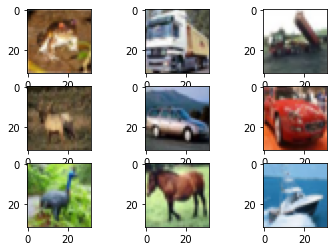

In [3]:
visualize_cifar10()

## SIFT Based Classification

**Load the dataset**

In [4]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

**Get descriptors for each image**

In [14]:
descriptors = []

start = time.time()
for img in X_train:
    des = getSIFT(to_gray(img))
    for d in des:
        descriptors.append(d);
end = time.time()
print("Descriptors for Kmeans - Time: %0.2f" % (end - start), "seconds")

Descriptors for Kmeans - Time: 52.99 seconds


### Training a bag of words system:

Compute the features for each image of the training set<br>
Cluster those features<br>
Label each cluster with the images that have features in that cluster<br>
At this point the training is done and you can start with the testing as follows: <br>

Compute the features of the test image
For each feature, find the nearest cluster<br>
Add a tick for each training image that belong to this cluster<br>
Repeat for all features of the test image<br>
The image that has the highest number of ticks is the best match and the image with the second highest number of ticks is the second best match and so on<br>

**Cluster the descriptors**

In [15]:
start = time.time()
k = 100
#batch_size = np.size(os.listdir(img_path)) * 3
kmeans = MiniBatchKMeans(n_clusters=100, batch_size=100, verbose=1).fit(descriptors)
end = time.time()

Init 1/3 with method: k-means++
Inertia for init 1/3: 19902354.913112
Init 2/3 with method: k-means++
Inertia for init 2/3: 19807110.115873
Init 3/3 with method: k-means++
Inertia for init 3/3: 20349613.499802
Minibatch iteration 1/650400: mean batch inertia: 108813.018292, ewa inertia: 108813.018292 
Minibatch iteration 2/650400: mean batch inertia: 108009.306352, ewa inertia: 108812.771125 
Minibatch iteration 3/650400: mean batch inertia: 107748.438692, ewa inertia: 108812.443808 
Minibatch iteration 4/650400: mean batch inertia: 105253.399958, ewa inertia: 108811.349287 
Minibatch iteration 5/650400: mean batch inertia: 103334.841128, ewa inertia: 108809.665083 
Minibatch iteration 6/650400: mean batch inertia: 105125.273330, ewa inertia: 108808.532013 
Minibatch iteration 7/650400: mean batch inertia: 100563.912602, ewa inertia: 108805.996526 
Minibatch iteration 8/650400: mean batch inertia: 99484.805483, ewa inertia: 108803.129958 
Minibatch iteration 9/650400: mean batch inerti

Minibatch iteration 88/650400: mean batch inertia: 91155.081098, ewa inertia: 108489.326683 
Minibatch iteration 89/650400: mean batch inertia: 94693.371475, ewa inertia: 108485.083979 
Minibatch iteration 90/650400: mean batch inertia: 90563.748815, ewa inertia: 108479.572588 
Minibatch iteration 91/650400: mean batch inertia: 95423.721114, ewa inertia: 108475.557491 
Minibatch iteration 92/650400: mean batch inertia: 91097.569368, ewa inertia: 108470.213197 
Minibatch iteration 93/650400: mean batch inertia: 91952.503729, ewa inertia: 108465.133466 
Minibatch iteration 94/650400: mean batch inertia: 91761.719412, ewa inertia: 108459.996625 
Minibatch iteration 95/650400: mean batch inertia: 92055.325646, ewa inertia: 108454.951658 
Minibatch iteration 96/650400: mean batch inertia: 94024.588071, ewa inertia: 108450.513853 
Minibatch iteration 97/650400: mean batch inertia: 92533.277069, ewa inertia: 108445.618788 
Minibatch iteration 98/650400: mean batch inertia: 94988.547006, ewa i

Minibatch iteration 208/650400: mean batch inertia: 93656.264535, ewa inertia: 107911.164845 
Minibatch iteration 209/650400: mean batch inertia: 90652.211574, ewa inertia: 107905.857158 
Minibatch iteration 210/650400: mean batch inertia: 91834.445311, ewa inertia: 107900.914678 
Minibatch iteration 211/650400: mean batch inertia: 92952.995763, ewa inertia: 107896.317709 
Minibatch iteration 212/650400: mean batch inertia: 95507.207984, ewa inertia: 107892.507656 
Minibatch iteration 213/650400: mean batch inertia: 90913.425318, ewa inertia: 107887.286038 
Minibatch iteration 214/650400: mean batch inertia: 92458.119772, ewa inertia: 107882.541070 
Minibatch iteration 215/650400: mean batch inertia: 92553.388916, ewa inertia: 107877.826859 
Minibatch iteration 216/650400: mean batch inertia: 91846.853560, ewa inertia: 107872.896816 
Minibatch iteration 217/650400: mean batch inertia: 93146.670457, ewa inertia: 107868.368024 
Minibatch iteration 218/650400: mean batch inertia: 93032.79

Minibatch iteration 337/650400: mean batch inertia: 90866.738554, ewa inertia: 107272.839805 
Minibatch iteration 338/650400: mean batch inertia: 91516.749388, ewa inertia: 107267.994297 
Minibatch iteration 339/650400: mean batch inertia: 92503.547042, ewa inertia: 107263.453751 
Minibatch iteration 340/650400: mean batch inertia: 89745.363574, ewa inertia: 107258.066371 
Minibatch iteration 341/650400: mean batch inertia: 88832.514147, ewa inertia: 107252.399917 
Minibatch iteration 342/650400: mean batch inertia: 93393.932112, ewa inertia: 107248.137989 
Minibatch iteration 343/650400: mean batch inertia: 90184.994879, ewa inertia: 107242.890520 
Minibatch iteration 344/650400: mean batch inertia: 89836.851416, ewa inertia: 107237.537599 
Minibatch iteration 345/650400: mean batch inertia: 92738.857503, ewa inertia: 107233.078786 
Minibatch iteration 346/650400: mean batch inertia: 93742.164655, ewa inertia: 107228.929893 
Minibatch iteration 347/650400: mean batch inertia: 92105.32

Minibatch iteration 468/650400: mean batch inertia: 89954.671175, ewa inertia: 106648.806036 
Minibatch iteration 469/650400: mean batch inertia: 92573.248820, ewa inertia: 106644.477346 
Minibatch iteration 470/650400: mean batch inertia: 91514.838718, ewa inertia: 106639.824492 
Minibatch iteration 471/650400: mean batch inertia: 93364.866980, ewa inertia: 106635.742012 
Minibatch iteration 472/650400: mean batch inertia: 89994.277519, ewa inertia: 106630.624223 
Minibatch iteration 473/650400: mean batch inertia: 93714.544180, ewa inertia: 106626.652110 
Minibatch iteration 474/650400: mean batch inertia: 92391.569036, ewa inertia: 106622.274361 
Minibatch iteration 475/650400: mean batch inertia: 86913.885212, ewa inertia: 106616.213393 
Minibatch iteration 476/650400: mean batch inertia: 91246.815206, ewa inertia: 106611.486805 
Minibatch iteration 477/650400: mean batch inertia: 93443.572966, ewa inertia: 106607.437245 
Minibatch iteration 478/650400: mean batch inertia: 92243.15

Minibatch iteration 582/650400: mean batch inertia: 93172.947885, ewa inertia: 106117.956822 
Minibatch iteration 583/650400: mean batch inertia: 91968.022642, ewa inertia: 106113.605259 
Minibatch iteration 584/650400: mean batch inertia: 91054.071571, ewa inertia: 106108.973964 
Minibatch iteration 585/650400: mean batch inertia: 93814.503374, ewa inertia: 106105.193016 
Minibatch iteration 586/650400: mean batch inertia: 92245.692381, ewa inertia: 106100.930771 
Minibatch iteration 587/650400: mean batch inertia: 94699.691250, ewa inertia: 106097.424520 
Minibatch iteration 588/650400: mean batch inertia: 90591.864838, ewa inertia: 106092.656059 
Minibatch iteration 589/650400: mean batch inertia: 90157.105174, ewa inertia: 106087.755361 
Minibatch iteration 590/650400: mean batch inertia: 93566.718193, ewa inertia: 106083.904736 
Minibatch iteration 591/650400: mean batch inertia: 90883.660996, ewa inertia: 106079.230169 
Minibatch iteration 592/650400: mean batch inertia: 92136.32

Minibatch iteration 712/650400: mean batch inertia: 84105.605853, ewa inertia: 105524.843622 
Minibatch iteration 713/650400: mean batch inertia: 91505.544306, ewa inertia: 105520.532233 
Minibatch iteration 714/650400: mean batch inertia: 90952.328806, ewa inertia: 105516.052039 
Minibatch iteration 715/650400: mean batch inertia: 89868.736493, ewa inertia: 105511.239982 
Minibatch iteration 716/650400: mean batch inertia: 89702.044620, ewa inertia: 105506.378143 
Minibatch iteration 717/650400: mean batch inertia: 92788.260884, ewa inertia: 105502.466909 
Minibatch iteration 718/650400: mean batch inertia: 93111.996009, ewa inertia: 105498.656438 
Minibatch iteration 719/650400: mean batch inertia: 89866.834758, ewa inertia: 105493.849147 
Minibatch iteration 720/650400: mean batch inertia: 93556.109225, ewa inertia: 105490.177905 
Minibatch iteration 721/650400: mean batch inertia: 96070.619242, ewa inertia: 105487.281086 
Minibatch iteration 722/650400: mean batch inertia: 89834.53

Minibatch iteration 833/650400: mean batch inertia: 91185.218869, ewa inertia: 104981.976156 
Minibatch iteration 834/650400: mean batch inertia: 89036.832826, ewa inertia: 104977.072508 
Minibatch iteration 835/650400: mean batch inertia: 90187.516795, ewa inertia: 104972.524241 
Minibatch iteration 836/650400: mean batch inertia: 89380.581520, ewa inertia: 104967.729213 
Minibatch iteration 837/650400: mean batch inertia: 89530.175988, ewa inertia: 104962.981666 
Minibatch iteration 838/650400: mean batch inertia: 90290.044652, ewa inertia: 104958.469262 
Minibatch iteration 839/650400: mean batch inertia: 91211.883762, ewa inertia: 104954.241742 
Minibatch iteration 840/650400: mean batch inertia: 91659.900012, ewa inertia: 104950.153301 
Minibatch iteration 841/650400: mean batch inertia: 92135.261236, ewa inertia: 104946.212307 
Minibatch iteration 842/650400: mean batch inertia: 90269.177175, ewa inertia: 104941.698643 
Minibatch iteration 843/650400: mean batch inertia: 91542.98

Minibatch iteration 953/650400: mean batch inertia: 88928.771418, ewa inertia: 104463.404948 
Minibatch iteration 954/650400: mean batch inertia: 90451.960877, ewa inertia: 104459.095975 
Minibatch iteration 955/650400: mean batch inertia: 92809.280405, ewa inertia: 104455.513280 
Minibatch iteration 956/650400: mean batch inertia: 89577.057511, ewa inertia: 104450.937673 
Minibatch iteration 957/650400: mean batch inertia: 89877.324129, ewa inertia: 104446.455814 
Minibatch iteration 958/650400: mean batch inertia: 89372.483332, ewa inertia: 104441.820080 
Minibatch iteration 959/650400: mean batch inertia: 91734.582548, ewa inertia: 104437.912192 
Minibatch iteration 960/650400: mean batch inertia: 87896.772931, ewa inertia: 104432.825256 
Minibatch iteration 961/650400: mean batch inertia: 87063.038541, ewa inertia: 104427.483484 
Minibatch iteration 962/650400: mean batch inertia: 91828.435684, ewa inertia: 104423.608869 
Minibatch iteration 963/650400: mean batch inertia: 94489.98

Minibatch iteration 1069/650400: mean batch inertia: 86941.351688, ewa inertia: 103982.729524 
Minibatch iteration 1070/650400: mean batch inertia: 91362.797947, ewa inertia: 103978.848486 
Minibatch iteration 1071/650400: mean batch inertia: 91344.974123, ewa inertia: 103974.963161 
Minibatch iteration 1072/650400: mean batch inertia: 90592.378430, ewa inertia: 103970.847582 
Minibatch iteration 1073/650400: mean batch inertia: 90872.010410, ewa inertia: 103966.819266 
Minibatch iteration 1074/650400: mean batch inertia: 88377.828291, ewa inertia: 103962.025146 
Minibatch iteration 1075/650400: mean batch inertia: 90021.733586, ewa inertia: 103957.738055 
Minibatch iteration 1076/650400: mean batch inertia: 92521.496958, ewa inertia: 103954.221040 
Minibatch iteration 1077/650400: mean batch inertia: 87285.970580, ewa inertia: 103949.095013 
Minibatch iteration 1078/650400: mean batch inertia: 90140.956576, ewa inertia: 103944.848563 
Minibatch iteration 1079/650400: mean batch inerti

Minibatch iteration 1190/650400: mean batch inertia: 90539.617944, ewa inertia: 103481.492550 
Minibatch iteration 1191/650400: mean batch inertia: 91115.510419, ewa inertia: 103477.689610 
Minibatch iteration 1192/650400: mean batch inertia: 85087.229118, ewa inertia: 103472.033948 
Minibatch iteration 1193/650400: mean batch inertia: 89673.741752, ewa inertia: 103467.790526 
Minibatch iteration 1194/650400: mean batch inertia: 93138.884668, ewa inertia: 103464.614053 
Minibatch iteration 1195/650400: mean batch inertia: 90778.925126, ewa inertia: 103460.712792 
Minibatch iteration 1196/650400: mean batch inertia: 92284.434275, ewa inertia: 103457.275725 
Minibatch iteration 1197/650400: mean batch inertia: 89001.458409, ewa inertia: 103452.830093 
Minibatch iteration 1198/650400: mean batch inertia: 86928.394187, ewa inertia: 103447.748293 
Minibatch iteration 1199/650400: mean batch inertia: 87826.812624, ewa inertia: 103442.944350 
Minibatch iteration 1200/650400: mean batch inerti

Minibatch iteration 1312/650400: mean batch inertia: 95312.326497, ewa inertia: 103003.745602 
Minibatch iteration 1313/650400: mean batch inertia: 90032.241959, ewa inertia: 102999.756444 
Minibatch iteration 1314/650400: mean batch inertia: 90692.558312, ewa inertia: 102995.971582 
Minibatch iteration 1315/650400: mean batch inertia: 87316.912525, ewa inertia: 102991.149764 
Minibatch iteration 1316/650400: mean batch inertia: 92292.296241, ewa inertia: 102987.859519 
Minibatch iteration 1317/650400: mean batch inertia: 90708.160254, ewa inertia: 102984.083114 
Minibatch iteration 1318/650400: mean batch inertia: 90935.676801, ewa inertia: 102980.377839 
Minibatch iteration 1319/650400: mean batch inertia: 93287.453861, ewa inertia: 102977.396951 
Minibatch iteration 1320/650400: mean batch inertia: 87984.251806, ewa inertia: 102972.786073 
Minibatch iteration 1321/650400: mean batch inertia: 92375.649518, ewa inertia: 102969.527110 
Minibatch iteration 1322/650400: mean batch inerti

Minibatch iteration 1434/650400: mean batch inertia: 90471.046206, ewa inertia: 102551.026931 
Minibatch iteration 1435/650400: mean batch inertia: 90106.936316, ewa inertia: 102547.199970 
Minibatch iteration 1436/650400: mean batch inertia: 87600.348693, ewa inertia: 102542.603329 
Minibatch iteration 1437/650400: mean batch inertia: 91372.697416, ewa inertia: 102539.168221 
Minibatch iteration 1438/650400: mean batch inertia: 94129.025443, ewa inertia: 102536.581830 
Minibatch iteration 1439/650400: mean batch inertia: 91943.142297, ewa inertia: 102533.324004 
Minibatch iteration 1440/650400: mean batch inertia: 89870.477943, ewa inertia: 102529.429769 
Minibatch iteration 1441/650400: mean batch inertia: 90286.055794, ewa inertia: 102525.664535 
Minibatch iteration 1442/650400: mean batch inertia: 88593.021083, ewa inertia: 102521.379795 
Minibatch iteration 1443/650400: mean batch inertia: 86304.178537, ewa inertia: 102516.392481 
Minibatch iteration 1444/650400: mean batch inerti

Minibatch iteration 1561/650400: mean batch inertia: 93385.839352, ewa inertia: 102090.796757 
Minibatch iteration 1562/650400: mean batch inertia: 87011.877642, ewa inertia: 102086.159501 
Minibatch iteration 1563/650400: mean batch inertia: 90133.086391, ewa inertia: 102082.483543 
Minibatch iteration 1564/650400: mean batch inertia: 91020.149122, ewa inertia: 102079.081517 
Minibatch iteration 1565/650400: mean batch inertia: 93634.609452, ewa inertia: 102076.484569 
Minibatch iteration 1566/650400: mean batch inertia: 88246.177902, ewa inertia: 102072.231301 
Minibatch iteration 1567/650400: mean batch inertia: 90409.858740, ewa inertia: 102068.644744 
Minibatch iteration 1568/650400: mean batch inertia: 89170.466662, ewa inertia: 102064.678136 
Minibatch iteration 1569/650400: mean batch inertia: 91439.885201, ewa inertia: 102061.410668 
Minibatch iteration 1570/650400: mean batch inertia: 90485.483186, ewa inertia: 102057.850696 
Minibatch iteration 1571/650400: mean batch inerti

Minibatch iteration 1686/650400: mean batch inertia: 95146.248104, ewa inertia: 101653.994943 
Minibatch iteration 1687/650400: mean batch inertia: 92159.261947, ewa inertia: 101651.075005 
Minibatch iteration 1688/650400: mean batch inertia: 89968.292383, ewa inertia: 101647.482171 
Minibatch iteration 1689/650400: mean batch inertia: 90981.365223, ewa inertia: 101644.201994 
Minibatch iteration 1690/650400: mean batch inertia: 93354.003859, ewa inertia: 101641.652490 
Minibatch iteration 1691/650400: mean batch inertia: 89008.198794, ewa inertia: 101637.767293 
Minibatch iteration 1692/650400: mean batch inertia: 89979.582154, ewa inertia: 101634.182024 
Minibatch iteration 1693/650400: mean batch inertia: 95141.767847, ewa inertia: 101632.185396 
Minibatch iteration 1694/650400: mean batch inertia: 92337.900086, ewa inertia: 101629.327103 
Minibatch iteration 1695/650400: mean batch inertia: 89053.497108, ewa inertia: 101625.459627 
Minibatch iteration 1696/650400: mean batch inerti

Minibatch iteration 1804/650400: mean batch inertia: 87017.808712, ewa inertia: 101255.489426 
Minibatch iteration 1805/650400: mean batch inertia: 92068.892048, ewa inertia: 101252.664250 
Minibatch iteration 1806/650400: mean batch inertia: 88655.168230, ewa inertia: 101248.790112 
Minibatch iteration 1807/650400: mean batch inertia: 89121.137895, ewa inertia: 101245.060466 
Minibatch iteration 1808/650400: mean batch inertia: 92256.831167, ewa inertia: 101242.296295 
Minibatch iteration 1809/650400: mean batch inertia: 93621.196107, ewa inertia: 101239.952559 
Minibatch iteration 1810/650400: mean batch inertia: 87195.730832, ewa inertia: 101235.633506 
Minibatch iteration 1811/650400: mean batch inertia: 90814.973079, ewa inertia: 101232.428816 
Minibatch iteration 1812/650400: mean batch inertia: 92128.737190, ewa inertia: 101229.629136 
Minibatch iteration 1813/650400: mean batch inertia: 89005.252567, ewa inertia: 101225.869744 
Minibatch iteration 1814/650400: mean batch inerti

Minibatch iteration 1921/650400: mean batch inertia: 89368.833742, ewa inertia: 100882.589951 
Minibatch iteration 1922/650400: mean batch inertia: 87956.041740, ewa inertia: 100878.614619 
Minibatch iteration 1923/650400: mean batch inertia: 90338.190804, ewa inertia: 100875.373097 
Minibatch iteration 1924/650400: mean batch inertia: 90674.529447, ewa inertia: 100872.236008 
Minibatch iteration 1925/650400: mean batch inertia: 88706.169624, ewa inertia: 100868.494548 
Minibatch iteration 1926/650400: mean batch inertia: 92039.012959, ewa inertia: 100865.779196 
Minibatch iteration 1927/650400: mean batch inertia: 88565.361994, ewa inertia: 100861.996420 
Minibatch iteration 1928/650400: mean batch inertia: 88952.785878, ewa inertia: 100858.333952 
Minibatch iteration 1929/650400: mean batch inertia: 91049.176659, ewa inertia: 100855.317318 
Minibatch iteration 1930/650400: mean batch inertia: 92034.226538, ewa inertia: 100852.604547 
Minibatch iteration 1931/650400: mean batch inerti

Minibatch iteration 2007/650400: mean batch inertia: 93121.132452, ewa inertia: 100612.243848 
Minibatch iteration 2008/650400: mean batch inertia: 88014.470210, ewa inertia: 100608.369625 
Minibatch iteration 2009/650400: mean batch inertia: 91475.046378, ewa inertia: 100605.560832 
Minibatch iteration 2010/650400: mean batch inertia: 87684.325017, ewa inertia: 100601.587133 
Minibatch iteration 2011/650400: mean batch inertia: 90418.323800, ewa inertia: 100598.455450 
Minibatch iteration 2012/650400: mean batch inertia: 92986.949788, ewa inertia: 100596.114665 
Minibatch iteration 2013/650400: mean batch inertia: 87666.468727, ewa inertia: 100592.138381 
Minibatch iteration 2014/650400: mean batch inertia: 89363.087176, ewa inertia: 100588.685084 
Minibatch iteration 2015/650400: mean batch inertia: 93187.015241, ewa inertia: 100586.408830 
Minibatch iteration 2016/650400: mean batch inertia: 90507.690678, ewa inertia: 100583.309298 
Minibatch iteration 2017/650400: mean batch inerti

Minibatch iteration 2134/650400: mean batch inertia: 89297.397680, ewa inertia: 100221.330733 
Minibatch iteration 2135/650400: mean batch inertia: 93140.969996, ewa inertia: 100219.153293 
Minibatch iteration 2136/650400: mean batch inertia: 86286.221022, ewa inertia: 100214.868465 
Minibatch iteration 2137/650400: mean batch inertia: 86629.500808, ewa inertia: 100210.690524 
Minibatch iteration 2138/650400: mean batch inertia: 95117.396094, ewa inertia: 100209.124171 
Minibatch iteration 2139/650400: mean batch inertia: 87603.718072, ewa inertia: 100205.247601 
Minibatch iteration 2140/650400: mean batch inertia: 94031.448531, ewa inertia: 100203.348958 
Minibatch iteration 2141/650400: mean batch inertia: 91589.874846, ewa inertia: 100200.700035 
Minibatch iteration 2142/650400: mean batch inertia: 90671.289171, ewa inertia: 100197.769433 
Minibatch iteration 2143/650400: mean batch inertia: 84470.609538, ewa inertia: 100192.932822 
Minibatch iteration 2144/650400: mean batch inerti

Minibatch iteration 2253/650400: mean batch inertia: 88238.922470, ewa inertia: 99863.036714 
Minibatch iteration 2254/650400: mean batch inertia: 90964.228083, ewa inertia: 99860.300042 
Minibatch iteration 2255/650400: mean batch inertia: 89012.005136, ewa inertia: 99856.963840 
Minibatch iteration 2256/650400: mean batch inertia: 89867.151076, ewa inertia: 99853.891649 
Minibatch iteration 2257/650400: mean batch inertia: 90915.016965, ewa inertia: 99851.142655 
Minibatch iteration 2258/650400: mean batch inertia: 89669.613053, ewa inertia: 99848.011505 
Minibatch iteration 2259/650400: mean batch inertia: 90396.715548, ewa inertia: 99845.104925 
Minibatch iteration 2260/650400: mean batch inertia: 94335.192595, ewa inertia: 99843.410449 
Minibatch iteration 2261/650400: mean batch inertia: 90389.133197, ewa inertia: 99840.502952 
Minibatch iteration 2262/650400: mean batch inertia: 89925.467935, ewa inertia: 99837.453758 
Minibatch iteration 2263/650400: mean batch inertia: 90885.2

Minibatch iteration 2382/650400: mean batch inertia: 87941.598478, ewa inertia: 99491.171707 
Minibatch iteration 2383/650400: mean batch inertia: 91153.433664, ewa inertia: 99488.607582 
Minibatch iteration 2384/650400: mean batch inertia: 90674.914383, ewa inertia: 99485.897086 
Minibatch iteration 2385/650400: mean batch inertia: 89848.334349, ewa inertia: 99482.933223 
Minibatch iteration 2386/650400: mean batch inertia: 90916.591254, ewa inertia: 99480.298796 
Minibatch iteration 2387/650400: mean batch inertia: 89382.087485, ewa inertia: 99477.193269 
Minibatch iteration 2388/650400: mean batch inertia: 90502.022562, ewa inertia: 99474.433113 
Minibatch iteration 2389/650400: mean batch inertia: 89643.585546, ewa inertia: 99471.409809 
Minibatch iteration 2390/650400: mean batch inertia: 87817.667876, ewa inertia: 99467.825906 
Minibatch iteration 2391/650400: mean batch inertia: 89423.599889, ewa inertia: 99464.736981 
Minibatch iteration 2392/650400: mean batch inertia: 88010.8

Minibatch iteration 2500/650400: mean batch inertia: 90526.212605, ewa inertia: 99163.815382 
Minibatch iteration 2501/650400: mean batch inertia: 86250.069412, ewa inertia: 99159.843987 
Minibatch iteration 2502/650400: mean batch inertia: 90750.150998, ewa inertia: 99157.257734 
Minibatch iteration 2503/650400: mean batch inertia: 92707.129443, ewa inertia: 99155.274110 
Minibatch iteration 2504/650400: mean batch inertia: 89980.407591, ewa inertia: 99152.452542 
Minibatch iteration 2505/650400: mean batch inertia: 89348.241665, ewa inertia: 99149.437429 
Minibatch iteration 2506/650400: mean batch inertia: 89147.853277, ewa inertia: 99146.361618 
Minibatch iteration 2507/650400: mean batch inertia: 91187.166482, ewa inertia: 99143.913908 
Minibatch iteration 2508/650400: mean batch inertia: 89544.673535, ewa inertia: 99140.961830 
Minibatch iteration 2509/650400: mean batch inertia: 90209.216434, ewa inertia: 99138.215029 
Minibatch iteration 2510/650400: mean batch inertia: 93522.6

Minibatch iteration 2624/650400: mean batch inertia: 90763.541440, ewa inertia: 98837.237761 
Minibatch iteration 2625/650400: mean batch inertia: 92395.918249, ewa inertia: 98835.256847 
Minibatch iteration 2626/650400: mean batch inertia: 92076.481197, ewa inertia: 98833.178305 
Minibatch iteration 2627/650400: mean batch inertia: 94473.915827, ewa inertia: 98831.837690 
Minibatch iteration 2628/650400: mean batch inertia: 87785.418433, ewa inertia: 98828.440558 
Minibatch iteration 2629/650400: mean batch inertia: 87618.706473, ewa inertia: 98824.993202 
Minibatch iteration 2630/650400: mean batch inertia: 93701.768790, ewa inertia: 98823.417645 
Minibatch iteration 2631/650400: mean batch inertia: 93130.260212, ewa inertia: 98821.666814 
Minibatch iteration 2632/650400: mean batch inertia: 92423.881420, ewa inertia: 98819.699288 
Minibatch iteration 2633/650400: mean batch inertia: 90813.718644, ewa inertia: 98817.237190 
Minibatch iteration 2634/650400: mean batch inertia: 89874.0

Minibatch iteration 2747/650400: mean batch inertia: 89529.447556, ewa inertia: 98526.556763 
Minibatch iteration 2748/650400: mean batch inertia: 87996.974445, ewa inertia: 98523.318575 
Minibatch iteration 2749/650400: mean batch inertia: 92316.148731, ewa inertia: 98521.409669 
Minibatch iteration 2750/650400: mean batch inertia: 91012.596248, ewa inertia: 98519.100466 
Minibatch iteration 2751/650400: mean batch inertia: 90056.965318, ewa inertia: 98516.498085 
Minibatch iteration 2752/650400: mean batch inertia: 89958.614876, ewa inertia: 98513.866259 
Minibatch iteration 2753/650400: mean batch inertia: 92820.127320, ewa inertia: 98512.115250 
Minibatch iteration 2754/650400: mean batch inertia: 86576.150311, ewa inertia: 98508.444554 
Minibatch iteration 2755/650400: mean batch inertia: 87795.600653, ewa inertia: 98505.150008 
Minibatch iteration 2756/650400: mean batch inertia: 87827.200357, ewa inertia: 98501.866192 
Minibatch iteration 2757/650400: mean batch inertia: 88370.8

Minibatch iteration 2834/650400: mean batch inertia: 89345.742012, ewa inertia: 98305.106262 
Minibatch iteration 2835/650400: mean batch inertia: 92861.348948, ewa inertia: 98303.432130 
Minibatch iteration 2836/650400: mean batch inertia: 87732.839582, ewa inertia: 98300.181330 
Minibatch iteration 2837/650400: mean batch inertia: 89537.270577, ewa inertia: 98297.486451 
Minibatch iteration 2838/650400: mean batch inertia: 88716.057471, ewa inertia: 98294.539852 
Minibatch iteration 2839/650400: mean batch inertia: 91588.401538, ewa inertia: 98292.477497 
Minibatch iteration 2840/650400: mean batch inertia: 88654.924412, ewa inertia: 98289.513637 
Minibatch iteration 2841/650400: mean batch inertia: 88130.795723, ewa inertia: 98286.389502 
Minibatch iteration 2842/650400: mean batch inertia: 92659.464342, ewa inertia: 98284.659041 
Minibatch iteration 2843/650400: mean batch inertia: 90035.023707, ewa inertia: 98282.122010 
Minibatch iteration 2844/650400: mean batch inertia: 89475.9

Minibatch iteration 2940/650400: mean batch inertia: 87760.913652, ewa inertia: 98047.580642 
Minibatch iteration 2941/650400: mean batch inertia: 89855.913992, ewa inertia: 98045.061440 
Minibatch iteration 2942/650400: mean batch inertia: 92376.468408, ewa inertia: 98043.318164 
Minibatch iteration 2943/650400: mean batch inertia: 92110.583491, ewa inertia: 98041.493656 
Minibatch iteration 2944/650400: mean batch inertia: 88162.848201, ewa inertia: 98038.455652 
Minibatch iteration 2945/650400: mean batch inertia: 91173.122018, ewa inertia: 98036.344340 
Minibatch iteration 2946/650400: mean batch inertia: 89698.944310, ewa inertia: 98033.780319 
Minibatch iteration 2947/650400: mean batch inertia: 90958.033584, ewa inertia: 98031.604298 
Minibatch iteration 2948/650400: mean batch inertia: 89532.853241, ewa inertia: 98028.990657 
Minibatch iteration 2949/650400: mean batch inertia: 89090.783213, ewa inertia: 98026.241868 
Minibatch iteration 2950/650400: mean batch inertia: 89674.7

Minibatch iteration 3042/650400: mean batch inertia: 88441.812529, ewa inertia: 97810.784860 
Minibatch iteration 3043/650400: mean batch inertia: 90357.880567, ewa inertia: 97808.492851 
Minibatch iteration 3044/650400: mean batch inertia: 92419.774950, ewa inertia: 97806.835645 
Minibatch iteration 3045/650400: mean batch inertia: 89227.782581, ewa inertia: 97804.197309 
Minibatch iteration 3046/650400: mean batch inertia: 88474.519489, ewa inertia: 97801.328131 
Minibatch iteration 3047/650400: mean batch inertia: 91749.250931, ewa inertia: 97799.466921 
Minibatch iteration 3048/650400: mean batch inertia: 88047.553434, ewa inertia: 97796.467891 
Minibatch iteration 3049/650400: mean batch inertia: 93197.946198, ewa inertia: 97795.053697 
Minibatch iteration 3050/650400: mean batch inertia: 90913.085786, ewa inertia: 97792.937269 
Minibatch iteration 3051/650400: mean batch inertia: 90172.885693, ewa inertia: 97790.593856 
Minibatch iteration 3052/650400: mean batch inertia: 86388.5

Minibatch iteration 3133/650400: mean batch inertia: 86383.185617, ewa inertia: 97605.863494 
Minibatch iteration 3134/650400: mean batch inertia: 88097.225428, ewa inertia: 97602.939280 
Minibatch iteration 3135/650400: mean batch inertia: 91769.240515, ewa inertia: 97601.145228 
Minibatch iteration 3136/650400: mean batch inertia: 94060.863521, ewa inertia: 97600.056477 
Minibatch iteration 3137/650400: mean batch inertia: 92872.231737, ewa inertia: 97598.602518 
Minibatch iteration 3138/650400: mean batch inertia: 86898.901948, ewa inertia: 97595.312013 
Minibatch iteration 3139/650400: mean batch inertia: 88054.449408, ewa inertia: 97592.377889 
Minibatch iteration 3140/650400: mean batch inertia: 91396.030446, ewa inertia: 97590.472311 
Minibatch iteration 3141/650400: mean batch inertia: 91594.691034, ewa inertia: 97588.628414 
Minibatch iteration 3142/650400: mean batch inertia: 91619.995870, ewa inertia: 97586.792867 
Minibatch iteration 3143/650400: mean batch inertia: 85310.5

Minibatch iteration 3240/650400: mean batch inertia: 89501.553729, ewa inertia: 97361.221837 
Minibatch iteration 3241/650400: mean batch inertia: 88299.594908, ewa inertia: 97358.435094 
Minibatch iteration 3242/650400: mean batch inertia: 88189.634554, ewa inertia: 97355.615390 
Minibatch iteration 3243/650400: mean batch inertia: 88075.823514, ewa inertia: 97352.761554 
Minibatch iteration 3244/650400: mean batch inertia: 91122.198377, ewa inertia: 97350.845454 
Minibatch iteration 3245/650400: mean batch inertia: 87512.114673, ewa inertia: 97347.819725 
Minibatch iteration 3246/650400: mean batch inertia: 88936.640451, ewa inertia: 97345.233015 
Minibatch iteration 3247/650400: mean batch inertia: 88613.986040, ewa inertia: 97342.547874 
Minibatch iteration 3248/650400: mean batch inertia: 88637.714736, ewa inertia: 97339.870856 
Minibatch iteration 3249/650400: mean batch inertia: 90375.740637, ewa inertia: 97337.729160 
Minibatch iteration 3250/650400: mean batch inertia: 91403.6

Minibatch iteration 3348/650400: mean batch inertia: 89685.437711, ewa inertia: 97124.763921 
Minibatch iteration 3349/650400: mean batch inertia: 89915.305389, ewa inertia: 97122.546779 
Minibatch iteration 3350/650400: mean batch inertia: 91842.968093, ewa inertia: 97120.923137 
Minibatch iteration 3351/650400: mean batch inertia: 88975.315743, ewa inertia: 97118.418099 
Minibatch iteration 3352/650400: mean batch inertia: 92065.642863, ewa inertia: 97116.864207 
Minibatch iteration 3353/650400: mean batch inertia: 89411.976789, ewa inertia: 97114.494705 
Minibatch iteration 3354/650400: mean batch inertia: 88656.677153, ewa inertia: 97111.893652 
Minibatch iteration 3355/650400: mean batch inertia: 88515.454237, ewa inertia: 97109.249968 
Minibatch iteration 3356/650400: mean batch inertia: 88830.905144, ewa inertia: 97106.704109 
Minibatch iteration 3357/650400: mean batch inertia: 91501.853801, ewa inertia: 97104.980436 
Minibatch iteration 3358/650400: mean batch inertia: 88422.2

Minibatch iteration 3456/650400: mean batch inertia: 90185.315306, ewa inertia: 96896.422499 
Minibatch iteration 3457/650400: mean batch inertia: 90453.097408, ewa inertia: 96894.440968 
Minibatch iteration 3458/650400: mean batch inertia: 87524.226055, ewa inertia: 96891.559324 
Minibatch iteration 3459/650400: mean batch inertia: 88808.004247, ewa inertia: 96889.073369 
Minibatch iteration 3460/650400: mean batch inertia: 87518.126936, ewa inertia: 96886.191499 
Minibatch iteration 3461/650400: mean batch inertia: 88244.799912, ewa inertia: 96883.533991 
Minibatch iteration 3462/650400: mean batch inertia: 92245.031182, ewa inertia: 96882.107501 
Minibatch iteration 3463/650400: mean batch inertia: 93534.610481, ewa inertia: 96881.078038 
Minibatch iteration 3464/650400: mean batch inertia: 87043.319903, ewa inertia: 96878.052608 
Minibatch iteration 3465/650400: mean batch inertia: 90395.913232, ewa inertia: 96876.059141 
Minibatch iteration 3466/650400: mean batch inertia: 88363.3

Minibatch iteration 3564/650400: mean batch inertia: 89241.243914, ewa inertia: 96670.641434 
Minibatch iteration 3565/650400: mean batch inertia: 88959.571228, ewa inertia: 96668.270030 
Minibatch iteration 3566/650400: mean batch inertia: 85738.253082, ewa inertia: 96664.908696 
Minibatch iteration 3567/650400: mean batch inertia: 90345.432021, ewa inertia: 96662.965252 
Minibatch iteration 3568/650400: mean batch inertia: 90618.530129, ewa inertia: 96661.106392 
Minibatch iteration 3569/650400: mean batch inertia: 93711.456967, ewa inertia: 96660.199280 
Minibatch iteration 3570/650400: mean batch inertia: 86499.702724, ewa inertia: 96657.074598 
Minibatch iteration 3571/650400: mean batch inertia: 86249.101880, ewa inertia: 96653.873809 
Minibatch iteration 3572/650400: mean batch inertia: 90206.628036, ewa inertia: 96651.891072 
Minibatch iteration 3573/650400: mean batch inertia: 94382.418197, ewa inertia: 96651.193136 
Minibatch iteration 3574/650400: mean batch inertia: 92255.4

Minibatch iteration 3668/650400: mean batch inertia: 89290.074646, ewa inertia: 96467.977413 
Minibatch iteration 3669/650400: mean batch inertia: 89661.146970, ewa inertia: 96465.884092 
Minibatch iteration 3670/650400: mean batch inertia: 92759.940528, ewa inertia: 96464.744394 
Minibatch iteration 3671/650400: mean batch inertia: 91810.859919, ewa inertia: 96463.313174 
Minibatch iteration 3672/650400: mean batch inertia: 88162.412061, ewa inertia: 96460.760378 
Minibatch iteration 3673/650400: mean batch inertia: 86601.729278, ewa inertia: 96457.728407 
Minibatch iteration 3674/650400: mean batch inertia: 93247.225542, ewa inertia: 96456.741073 
Minibatch iteration 3675/650400: mean batch inertia: 88025.983116, ewa inertia: 96454.148342 
Minibatch iteration 3676/650400: mean batch inertia: 92950.391565, ewa inertia: 96453.070823 
Minibatch iteration 3677/650400: mean batch inertia: 90240.826135, ewa inertia: 96451.160357 
Minibatch iteration 3678/650400: mean batch inertia: 91695.4

Minibatch iteration 3779/650400: mean batch inertia: 87943.190781, ewa inertia: 96262.555579 
Minibatch iteration 3780/650400: mean batch inertia: 94774.569200, ewa inertia: 96262.097975 
Minibatch iteration 3781/650400: mean batch inertia: 88202.044611, ewa inertia: 96259.619248 
Minibatch iteration 3782/650400: mean batch inertia: 91412.771358, ewa inertia: 96258.128685 
Minibatch iteration 3783/650400: mean batch inertia: 89761.197557, ewa inertia: 96256.130669 
Minibatch iteration 3784/650400: mean batch inertia: 91796.648275, ewa inertia: 96254.759233 
Minibatch iteration 3785/650400: mean batch inertia: 91246.553426, ewa inertia: 96253.219048 
Minibatch iteration 3786/650400: mean batch inertia: 91244.633534, ewa inertia: 96251.678745 
Minibatch iteration 3787/650400: mean batch inertia: 87684.679448, ewa inertia: 96249.044116 
Minibatch iteration 3788/650400: mean batch inertia: 90694.730773, ewa inertia: 96247.335984 
Minibatch iteration 3789/650400: mean batch inertia: 92619.0

Minibatch iteration 3889/650400: mean batch inertia: 89359.017903, ewa inertia: 96076.792301 
Minibatch iteration 3890/650400: mean batch inertia: 92335.512263, ewa inertia: 96075.641736 
Minibatch iteration 3891/650400: mean batch inertia: 89052.662889, ewa inertia: 96073.481943 
Minibatch iteration 3892/650400: mean batch inertia: 91086.542753, ewa inertia: 96071.948297 
Minibatch iteration 3893/650400: mean batch inertia: 88878.434138, ewa inertia: 96069.736059 
Minibatch iteration 3894/650400: mean batch inertia: 88346.890024, ewa inertia: 96067.361034 
Minibatch iteration 3895/650400: mean batch inertia: 92688.359894, ewa inertia: 96066.321881 
Minibatch iteration 3896/650400: mean batch inertia: 92785.170045, ewa inertia: 96065.312821 
Minibatch iteration 3897/650400: mean batch inertia: 90074.994796, ewa inertia: 96063.470604 
Minibatch iteration 3898/650400: mean batch inertia: 88079.984279, ewa inertia: 96061.015423 
Minibatch iteration 3899/650400: mean batch inertia: 92321.1

Minibatch iteration 4001/650400: mean batch inertia: 93007.049868, ewa inertia: 95883.099223 
Minibatch iteration 4002/650400: mean batch inertia: 87981.479240, ewa inertia: 95880.669219 
Minibatch iteration 4003/650400: mean batch inertia: 90027.238519, ewa inertia: 95878.869099 
Minibatch iteration 4004/650400: mean batch inertia: 88230.027781, ewa inertia: 95876.516833 
Minibatch iteration 4005/650400: mean batch inertia: 93615.670814, ewa inertia: 95875.821549 
Minibatch iteration 4006/650400: mean batch inertia: 89056.321679, ewa inertia: 95873.724332 
Minibatch iteration 4007/650400: mean batch inertia: 91928.007986, ewa inertia: 95872.510897 
Minibatch iteration 4008/650400: mean batch inertia: 92795.208965, ewa inertia: 95871.564527 
Minibatch iteration 4009/650400: mean batch inertia: 93056.579037, ewa inertia: 95870.698827 
Minibatch iteration 4010/650400: mean batch inertia: 90828.142516, ewa inertia: 95869.148078 
Minibatch iteration 4011/650400: mean batch inertia: 88089.3

Minibatch iteration 4111/650400: mean batch inertia: 90721.616370, ewa inertia: 95694.527721 
Minibatch iteration 4112/650400: mean batch inertia: 87794.944755, ewa inertia: 95692.098343 
Minibatch iteration 4113/650400: mean batch inertia: 90000.579072, ewa inertia: 95690.348017 
Minibatch iteration 4114/650400: mean batch inertia: 91867.834354, ewa inertia: 95689.172470 
Minibatch iteration 4115/650400: mean batch inertia: 90853.164142, ewa inertia: 95687.685241 
Minibatch iteration 4116/650400: mean batch inertia: 91731.559969, ewa inertia: 95686.468604 
Minibatch iteration 4117/650400: mean batch inertia: 91709.344566, ewa inertia: 95685.245509 
Minibatch iteration 4118/650400: mean batch inertia: 91043.165067, ewa inertia: 95683.817919 
Minibatch iteration 4119/650400: mean batch inertia: 85787.982699, ewa inertia: 95680.774629 
Minibatch iteration 4120/650400: mean batch inertia: 90977.225844, ewa inertia: 95679.328136 
Minibatch iteration 4121/650400: mean batch inertia: 89794.5

Minibatch iteration 4220/650400: mean batch inertia: 89978.479109, ewa inertia: 95515.176124 
Minibatch iteration 4221/650400: mean batch inertia: 93850.102039, ewa inertia: 95514.664060 
Minibatch iteration 4222/650400: mean batch inertia: 92444.871894, ewa inertia: 95513.719999 
Minibatch iteration 4223/650400: mean batch inertia: 91396.440183, ewa inertia: 95512.453802 
Minibatch iteration 4224/650400: mean batch inertia: 92972.264738, ewa inertia: 95511.672612 
Minibatch iteration 4225/650400: mean batch inertia: 87098.451934, ewa inertia: 95509.085274 
Minibatch iteration 4226/650400: mean batch inertia: 87384.660130, ewa inertia: 95506.586750 
Minibatch iteration 4227/650400: mean batch inertia: 89934.951176, ewa inertia: 95504.873292 
Minibatch iteration 4228/650400: mean batch inertia: 90103.518949, ewa inertia: 95503.212200 
Minibatch iteration 4229/650400: mean batch inertia: 88293.378085, ewa inertia: 95500.994943 
Minibatch iteration 4230/650400: mean batch inertia: 91506.1

Minibatch iteration 4322/650400: mean batch inertia: 91594.397728, ewa inertia: 95357.722441 
Minibatch iteration 4323/650400: mean batch inertia: 93317.985261, ewa inertia: 95357.095156 
Minibatch iteration 4324/650400: mean batch inertia: 90994.280650, ewa inertia: 95355.753449 
Minibatch iteration 4325/650400: mean batch inertia: 92797.052679, ewa inertia: 95354.966566 
Minibatch iteration 4326/650400: mean batch inertia: 88266.644248, ewa inertia: 95352.786677 
Minibatch iteration 4327/650400: mean batch inertia: 88005.038369, ewa inertia: 95350.527007 
Minibatch iteration 4328/650400: mean batch inertia: 90376.288550, ewa inertia: 95348.997267 
Minibatch iteration 4329/650400: mean batch inertia: 91194.390644, ewa inertia: 95347.719591 
Minibatch iteration 4330/650400: mean batch inertia: 88786.249507, ewa inertia: 95345.701727 
Minibatch iteration 4331/650400: mean batch inertia: 91590.308055, ewa inertia: 95344.546821 
Minibatch iteration 4332/650400: mean batch inertia: 93164.6

Minibatch iteration 4434/650400: mean batch inertia: 90348.049225, ewa inertia: 95183.591147 
Minibatch iteration 4435/650400: mean batch inertia: 92583.992751, ewa inertia: 95182.791686 
Minibatch iteration 4436/650400: mean batch inertia: 86777.999976, ewa inertia: 95180.206941 
Minibatch iteration 4437/650400: mean batch inertia: 86228.104137, ewa inertia: 95177.453879 
Minibatch iteration 4438/650400: mean batch inertia: 88527.033926, ewa inertia: 95175.408660 
Minibatch iteration 4439/650400: mean batch inertia: 90176.386522, ewa inertia: 95173.871298 
Minibatch iteration 4440/650400: mean batch inertia: 89507.341758, ewa inertia: 95172.128657 
Minibatch iteration 4441/650400: mean batch inertia: 86448.146608, ewa inertia: 95169.445750 
Minibatch iteration 4442/650400: mean batch inertia: 90062.944438, ewa inertia: 95167.875335 
Minibatch iteration 4443/650400: mean batch inertia: 90558.355129, ewa inertia: 95166.457759 
Minibatch iteration 4444/650400: mean batch inertia: 91491.7

Minibatch iteration 4536/650400: mean batch inertia: 92332.797634, ewa inertia: 95035.380661 
Minibatch iteration 4537/650400: mean batch inertia: 92323.377589, ewa inertia: 95034.546632 
Minibatch iteration 4538/650400: mean batch inertia: 88997.968623, ewa inertia: 95032.690189 
Minibatch iteration 4539/650400: mean batch inertia: 89607.068421, ewa inertia: 95031.021635 
Minibatch iteration 4540/650400: mean batch inertia: 92238.719221, ewa inertia: 95030.162911 
Minibatch iteration 4541/650400: mean batch inertia: 89198.223427, ewa inertia: 95028.369401 
Minibatch iteration 4542/650400: mean batch inertia: 93673.931148, ewa inertia: 95027.952867 
Minibatch iteration 4543/650400: mean batch inertia: 90200.808606, ewa inertia: 95026.468364 
Minibatch iteration 4544/650400: mean batch inertia: 92145.518381, ewa inertia: 95025.582379 
Minibatch iteration 4545/650400: mean batch inertia: 91004.369513, ewa inertia: 95024.345725 
Minibatch iteration 4546/650400: mean batch inertia: 90656.6

Minibatch iteration 4642/650400: mean batch inertia: 88732.835561, ewa inertia: 94873.685073 
Minibatch iteration 4643/650400: mean batch inertia: 88493.770209, ewa inertia: 94871.723043 
Minibatch iteration 4644/650400: mean batch inertia: 91113.901158, ewa inertia: 94870.567391 
Minibatch iteration 4645/650400: mean batch inertia: 86014.210328, ewa inertia: 94867.843774 
Minibatch iteration 4646/650400: mean batch inertia: 89644.926933, ewa inertia: 94866.237558 
Minibatch iteration 4647/650400: mean batch inertia: 91167.515301, ewa inertia: 94865.100081 
Minibatch iteration 4648/650400: mean batch inertia: 87526.701615, ewa inertia: 94862.843286 
Minibatch iteration 4649/650400: mean batch inertia: 89143.065450, ewa inertia: 94861.084269 
Minibatch iteration 4650/650400: mean batch inertia: 92244.374100, ewa inertia: 94860.279546 
Minibatch iteration 4651/650400: mean batch inertia: 88531.639899, ewa inertia: 94858.333284 
Minibatch iteration 4652/650400: mean batch inertia: 89892.6

Minibatch iteration 4745/650400: mean batch inertia: 87488.886137, ewa inertia: 94721.921957 
Minibatch iteration 4746/650400: mean batch inertia: 92044.922487, ewa inertia: 94721.098693 
Minibatch iteration 4747/650400: mean batch inertia: 89435.188017, ewa inertia: 94719.473105 
Minibatch iteration 4748/650400: mean batch inertia: 92802.027776, ewa inertia: 94718.883428 
Minibatch iteration 4749/650400: mean batch inertia: 90284.924657, ewa inertia: 94717.519842 
Minibatch iteration 4750/650400: mean batch inertia: 88964.520580, ewa inertia: 94715.750608 
Minibatch iteration 4751/650400: mean batch inertia: 89023.635567, ewa inertia: 94714.000099 
Minibatch iteration 4752/650400: mean batch inertia: 91668.638010, ewa inertia: 94713.063551 
Minibatch iteration 4753/650400: mean batch inertia: 94243.249202, ewa inertia: 94712.919068 
Minibatch iteration 4754/650400: mean batch inertia: 90690.788189, ewa inertia: 94711.682133 
Minibatch iteration 4755/650400: mean batch inertia: 90238.4

Minibatch iteration 4850/650400: mean batch inertia: 86563.555257, ewa inertia: 94573.138952 
Minibatch iteration 4851/650400: mean batch inertia: 88811.958986, ewa inertia: 94571.367203 
Minibatch iteration 4852/650400: mean batch inertia: 89330.555267, ewa inertia: 94569.755484 
Minibatch iteration 4853/650400: mean batch inertia: 91721.775270, ewa inertia: 94568.879637 
Minibatch iteration 4854/650400: mean batch inertia: 87211.659762, ewa inertia: 94566.617054 
Minibatch iteration 4855/650400: mean batch inertia: 87969.050547, ewa inertia: 94564.588089 
Minibatch iteration 4856/650400: mean batch inertia: 91165.293093, ewa inertia: 94563.542695 
Minibatch iteration 4857/650400: mean batch inertia: 92371.215113, ewa inertia: 94562.868484 
Minibatch iteration 4858/650400: mean batch inertia: 90586.795465, ewa inertia: 94561.645712 
Minibatch iteration 4859/650400: mean batch inertia: 90715.686918, ewa inertia: 94560.462955 
Minibatch iteration 4860/650400: mean batch inertia: 92612.5

Minibatch iteration 4954/650400: mean batch inertia: 91110.506780, ewa inertia: 94431.865402 
Minibatch iteration 4955/650400: mean batch inertia: 93061.077809, ewa inertia: 94431.443840 
Minibatch iteration 4956/650400: mean batch inertia: 85255.816456, ewa inertia: 94428.622038 
Minibatch iteration 4957/650400: mean batch inertia: 91121.667007, ewa inertia: 94427.605042 
Minibatch iteration 4958/650400: mean batch inertia: 90751.244996, ewa inertia: 94426.474442 
Minibatch iteration 4959/650400: mean batch inertia: 89723.758801, ewa inertia: 94425.028205 
Minibatch iteration 4960/650400: mean batch inertia: 92982.835820, ewa inertia: 94424.584684 
Minibatch iteration 4961/650400: mean batch inertia: 92723.906835, ewa inertia: 94424.061670 
Minibatch iteration 4962/650400: mean batch inertia: 87900.712216, ewa inertia: 94422.055529 
Minibatch iteration 4963/650400: mean batch inertia: 86032.703006, ewa inertia: 94419.475531 
Minibatch iteration 4964/650400: mean batch inertia: 89175.3

Minibatch iteration 5068/650400: mean batch inertia: 89650.323999, ewa inertia: 94298.377845 
Minibatch iteration 5069/650400: mean batch inertia: 89528.736902, ewa inertia: 94296.911026 
Minibatch iteration 5070/650400: mean batch inertia: 88494.366409, ewa inertia: 94295.126555 
Minibatch iteration 5071/650400: mean batch inertia: 93210.791342, ewa inertia: 94294.793087 
Minibatch iteration 5072/650400: mean batch inertia: 90341.934107, ewa inertia: 94293.577455 
Minibatch iteration 5073/650400: mean batch inertia: 91858.101391, ewa inertia: 94292.828467 
Minibatch iteration 5074/650400: mean batch inertia: 90033.525514, ewa inertia: 94291.518594 
Minibatch iteration 5075/650400: mean batch inertia: 89137.555016, ewa inertia: 94289.933583 
Minibatch iteration 5076/650400: mean batch inertia: 86591.744602, ewa inertia: 94287.566140 
Minibatch iteration 5077/650400: mean batch inertia: 92647.816741, ewa inertia: 94287.061864 
Minibatch iteration 5078/650400: mean batch inertia: 88377.6

Minibatch iteration 5174/650400: mean batch inertia: 91346.104845, ewa inertia: 94167.840545 
Minibatch iteration 5175/650400: mean batch inertia: 88978.057224, ewa inertia: 94166.244519 
Minibatch iteration 5176/650400: mean batch inertia: 88234.193016, ewa inertia: 94164.420221 
Minibatch iteration 5177/650400: mean batch inertia: 89911.145873, ewa inertia: 94163.112201 
Minibatch iteration 5178/650400: mean batch inertia: 88726.539004, ewa inertia: 94161.440279 
Minibatch iteration 5179/650400: mean batch inertia: 87170.112315, ewa inertia: 94159.290219 
Minibatch iteration 5180/650400: mean batch inertia: 89605.440917, ewa inertia: 94157.889763 
Minibatch iteration 5181/650400: mean batch inertia: 88865.792084, ewa inertia: 94156.262271 
Minibatch iteration 5182/650400: mean batch inertia: 87268.877031, ewa inertia: 94154.144177 
Minibatch iteration 5183/650400: mean batch inertia: 87603.633722, ewa inertia: 94152.129683 
Minibatch iteration 5184/650400: mean batch inertia: 91442.6

Minibatch iteration 5279/650400: mean batch inertia: 91818.197430, ewa inertia: 94036.549359 
Minibatch iteration 5280/650400: mean batch inertia: 89603.448258, ewa inertia: 94035.186037 
Minibatch iteration 5281/650400: mean batch inertia: 90343.920066, ewa inertia: 94034.050853 
Minibatch iteration 5282/650400: mean batch inertia: 91074.168861, ewa inertia: 94033.140594 
Minibatch iteration 5283/650400: mean batch inertia: 87705.181000, ewa inertia: 94031.194541 
Minibatch iteration 5284/650400: mean batch inertia: 90174.372718, ewa inertia: 94030.008443 
Minibatch iteration 5285/650400: mean batch inertia: 86486.712833, ewa inertia: 94027.688636 
Minibatch iteration 5286/650400: mean batch inertia: 86806.951357, ewa inertia: 94025.468025 
Minibatch iteration 5287/650400: mean batch inertia: 91124.538670, ewa inertia: 94024.575895 
Minibatch iteration 5288/650400: mean batch inertia: 87891.103450, ewa inertia: 94022.689654 
Minibatch iteration 5289/650400: mean batch inertia: 89266.3

Minibatch iteration 5385/650400: mean batch inertia: 89074.517334, ewa inertia: 93901.429107 
Minibatch iteration 5386/650400: mean batch inertia: 92860.035782, ewa inertia: 93901.108844 
Minibatch iteration 5387/650400: mean batch inertia: 91635.987079, ewa inertia: 93900.412246 
Minibatch iteration 5388/650400: mean batch inertia: 87763.902223, ewa inertia: 93898.525071 
Minibatch iteration 5389/650400: mean batch inertia: 91581.279528, ewa inertia: 93897.812443 
Minibatch iteration 5390/650400: mean batch inertia: 92015.760034, ewa inertia: 93897.233650 
Minibatch iteration 5391/650400: mean batch inertia: 90231.996852, ewa inertia: 93896.106471 
Minibatch iteration 5392/650400: mean batch inertia: 89523.954819, ewa inertia: 93894.761893 
Minibatch iteration 5393/650400: mean batch inertia: 92935.412126, ewa inertia: 93894.466862 
Minibatch iteration 5394/650400: mean batch inertia: 88953.506734, ewa inertia: 93892.947357 
Minibatch iteration 5395/650400: mean batch inertia: 90784.7

Minibatch iteration 5490/650400: mean batch inertia: 89715.062236, ewa inertia: 93783.383120 
Minibatch iteration 5491/650400: mean batch inertia: 89590.207044, ewa inertia: 93782.093582 
Minibatch iteration 5492/650400: mean batch inertia: 90349.217413, ewa inertia: 93781.037861 
Minibatch iteration 5493/650400: mean batch inertia: 93363.240392, ewa inertia: 93780.909375 
Minibatch iteration 5494/650400: mean batch inertia: 89992.170240, ewa inertia: 93779.744215 
Minibatch iteration 5495/650400: mean batch inertia: 93079.714607, ewa inertia: 93779.528933 
Minibatch iteration 5496/650400: mean batch inertia: 92718.808042, ewa inertia: 93779.202727 
Minibatch iteration 5497/650400: mean batch inertia: 91763.866823, ewa inertia: 93778.582946 
Minibatch iteration 5498/650400: mean batch inertia: 86993.783866, ewa inertia: 93776.496401 
Minibatch iteration 5499/650400: mean batch inertia: 89868.125160, ewa inertia: 93775.294450 
Minibatch iteration 5500/650400: mean batch inertia: 89808.6

Minibatch iteration 5599/650400: mean batch inertia: 91858.406459, ewa inertia: 93661.746894 
Minibatch iteration 5600/650400: mean batch inertia: 94267.058862, ewa inertia: 93661.933047 
Minibatch iteration 5601/650400: mean batch inertia: 87671.467124, ewa inertia: 93660.090784 
Minibatch iteration 5602/650400: mean batch inertia: 90917.107752, ewa inertia: 93659.247228 
Minibatch iteration 5603/650400: mean batch inertia: 91627.047516, ewa inertia: 93658.622261 
Minibatch iteration 5604/650400: mean batch inertia: 95206.084225, ewa inertia: 93659.098156 
Minibatch iteration 5605/650400: mean batch inertia: 88804.954777, ewa inertia: 93657.605349 
Minibatch iteration 5606/650400: mean batch inertia: 90299.547961, ewa inertia: 93656.572638 
Minibatch iteration 5607/650400: mean batch inertia: 89507.166529, ewa inertia: 93655.296561 
Minibatch iteration 5608/650400: mean batch inertia: 89410.859999, ewa inertia: 93653.991259 
Minibatch iteration 5609/650400: mean batch inertia: 92070.2

Minibatch iteration 5705/650400: mean batch inertia: 91893.066503, ewa inertia: 93560.803807 
Minibatch iteration 5706/650400: mean batch inertia: 91158.783153, ewa inertia: 93560.065108 
Minibatch iteration 5707/650400: mean batch inertia: 89232.610347, ewa inertia: 93558.734275 
Minibatch iteration 5708/650400: mean batch inertia: 87898.400064, ewa inertia: 93556.993539 
Minibatch iteration 5709/650400: mean batch inertia: 86187.091005, ewa inertia: 93554.727055 
Minibatch iteration 5710/650400: mean batch inertia: 89324.913720, ewa inertia: 93553.426251 
Minibatch iteration 5711/650400: mean batch inertia: 89712.143220, ewa inertia: 93552.244932 
Minibatch iteration 5712/650400: mean batch inertia: 90010.524646, ewa inertia: 93551.155738 
Minibatch iteration 5713/650400: mean batch inertia: 88769.534073, ewa inertia: 93549.685234 
Minibatch iteration 5714/650400: mean batch inertia: 90494.709283, ewa inertia: 93548.745730 
Minibatch iteration 5715/650400: mean batch inertia: 89735.6

Minibatch iteration 5795/650400: mean batch inertia: 91568.376999, ewa inertia: 93464.053900 
Minibatch iteration 5796/650400: mean batch inertia: 91423.947541, ewa inertia: 93463.426501 
Minibatch iteration 5797/650400: mean batch inertia: 91760.116866, ewa inertia: 93462.902678 
Minibatch iteration 5798/650400: mean batch inertia: 89677.881503, ewa inertia: 93461.738661 
Minibatch iteration 5799/650400: mean batch inertia: 91736.707489, ewa inertia: 93461.208158 
Minibatch iteration 5800/650400: mean batch inertia: 88908.649553, ewa inertia: 93459.808099 
Minibatch iteration 5801/650400: mean batch inertia: 85392.853689, ewa inertia: 93457.327249 
Minibatch iteration 5802/650400: mean batch inertia: 90339.137392, ewa inertia: 93456.368305 
Minibatch iteration 5803/650400: mean batch inertia: 88949.259933, ewa inertia: 93454.982223 
Minibatch iteration 5804/650400: mean batch inertia: 91285.974437, ewa inertia: 93454.315183 
Minibatch iteration 5805/650400: mean batch inertia: 89367.5

Minibatch iteration 5900/650400: mean batch inertia: 91550.886651, ewa inertia: 93352.257613 
Minibatch iteration 5901/650400: mean batch inertia: 87659.815105, ewa inertia: 93350.507003 
Minibatch iteration 5902/650400: mean batch inertia: 87136.020342, ewa inertia: 93348.595847 
Minibatch iteration 5903/650400: mean batch inertia: 86985.340264, ewa inertia: 93346.638940 
Minibatch iteration 5904/650400: mean batch inertia: 92370.763448, ewa inertia: 93346.338826 
Minibatch iteration 5905/650400: mean batch inertia: 89511.829450, ewa inertia: 93345.159591 
Minibatch iteration 5906/650400: mean batch inertia: 89119.491487, ewa inertia: 93343.860061 
Minibatch iteration 5907/650400: mean batch inertia: 90191.646430, ewa inertia: 93342.890653 
Minibatch iteration 5908/650400: mean batch inertia: 90248.286048, ewa inertia: 93341.938962 
Minibatch iteration 5909/650400: mean batch inertia: 88557.194393, ewa inertia: 93340.467498 
Minibatch iteration 5910/650400: mean batch inertia: 93098.5

Minibatch iteration 6009/650400: mean batch inertia: 90531.939614, ewa inertia: 93253.248138 
Minibatch iteration 6010/650400: mean batch inertia: 88720.913051, ewa inertia: 93251.854298 
Minibatch iteration 6011/650400: mean batch inertia: 88600.105940, ewa inertia: 93250.423734 
Minibatch iteration 6012/650400: mean batch inertia: 92218.684213, ewa inertia: 93250.106441 
Minibatch iteration 6013/650400: mean batch inertia: 89024.198119, ewa inertia: 93248.806837 
Minibatch iteration 6014/650400: mean batch inertia: 90998.886746, ewa inertia: 93248.114914 
Minibatch iteration 6015/650400: mean batch inertia: 87863.670647, ewa inertia: 93246.459023 
Minibatch iteration 6016/650400: mean batch inertia: 90826.963420, ewa inertia: 93245.714950 
Minibatch iteration 6017/650400: mean batch inertia: 92748.713739, ewa inertia: 93245.562106 
Minibatch iteration 6018/650400: mean batch inertia: 90907.338134, ewa inertia: 93244.843026 
Minibatch iteration 6019/650400: mean batch inertia: 89428.1

Minibatch iteration 6114/650400: mean batch inertia: 87929.034847, ewa inertia: 93153.541046 
Minibatch iteration 6115/650400: mean batch inertia: 90277.725097, ewa inertia: 93152.656639 
Minibatch iteration 6116/650400: mean batch inertia: 89366.676156, ewa inertia: 93151.492328 
Minibatch iteration 6117/650400: mean batch inertia: 91085.063690, ewa inertia: 93150.856834 
Minibatch iteration 6118/650400: mean batch inertia: 88308.470492, ewa inertia: 93149.367643 
Minibatch iteration 6119/650400: mean batch inertia: 91669.755420, ewa inertia: 93148.912615 
Minibatch iteration 6120/650400: mean batch inertia: 90366.659035, ewa inertia: 93148.056981 
Minibatch iteration 6121/650400: mean batch inertia: 91515.153166, ewa inertia: 93147.554811 
Minibatch iteration 6122/650400: mean batch inertia: 88017.262250, ewa inertia: 93145.977080 
Minibatch iteration 6123/650400: mean batch inertia: 91711.248366, ewa inertia: 93145.535854 
Minibatch iteration 6124/650400: mean batch inertia: 91254.6

Minibatch iteration 6205/650400: mean batch inertia: 91758.617025, ewa inertia: 93078.570449 
Minibatch iteration 6206/650400: mean batch inertia: 91381.245291, ewa inertia: 93078.048467 
Minibatch iteration 6207/650400: mean batch inertia: 92898.269273, ewa inertia: 93077.993179 
Minibatch iteration 6208/650400: mean batch inertia: 88408.180144, ewa inertia: 93076.557060 
Minibatch iteration 6209/650400: mean batch inertia: 85036.524963, ewa inertia: 93074.084490 
Minibatch iteration 6210/650400: mean batch inertia: 90304.821628, ewa inertia: 93073.232852 
Minibatch iteration 6211/650400: mean batch inertia: 92877.384962, ewa inertia: 93073.172622 
Minibatch iteration 6212/650400: mean batch inertia: 93971.600407, ewa inertia: 93073.448918 
Minibatch iteration 6213/650400: mean batch inertia: 90588.621375, ewa inertia: 93072.684753 
Minibatch iteration 6214/650400: mean batch inertia: 85153.404434, ewa inertia: 93070.249318 
Minibatch iteration 6215/650400: mean batch inertia: 89942.4

Minibatch iteration 6308/650400: mean batch inertia: 87363.222430, ewa inertia: 92985.581360 
Minibatch iteration 6309/650400: mean batch inertia: 93655.076116, ewa inertia: 92985.787252 
Minibatch iteration 6310/650400: mean batch inertia: 91740.569375, ewa inertia: 92985.404307 
Minibatch iteration 6311/650400: mean batch inertia: 87151.899767, ewa inertia: 92983.610315 
Minibatch iteration 6312/650400: mean batch inertia: 91571.413611, ewa inertia: 92983.176019 
Minibatch iteration 6313/650400: mean batch inertia: 89550.891254, ewa inertia: 92982.120480 
Minibatch iteration 6314/650400: mean batch inertia: 91356.710057, ewa inertia: 92981.620614 
Minibatch iteration 6315/650400: mean batch inertia: 94653.692077, ewa inertia: 92982.134830 
Minibatch iteration 6316/650400: mean batch inertia: 91488.984804, ewa inertia: 92981.675638 
Minibatch iteration 6317/650400: mean batch inertia: 89178.767866, ewa inertia: 92980.506121 
Minibatch iteration 6318/650400: mean batch inertia: 89134.3

Minibatch iteration 6413/650400: mean batch inertia: 91838.369657, ewa inertia: 92904.061663 
Minibatch iteration 6414/650400: mean batch inertia: 88709.822826, ewa inertia: 92902.771799 
Minibatch iteration 6415/650400: mean batch inertia: 88763.434050, ewa inertia: 92901.498819 
Minibatch iteration 6416/650400: mean batch inertia: 88785.541174, ewa inertia: 92900.233028 
Minibatch iteration 6417/650400: mean batch inertia: 87910.598270, ewa inertia: 92898.698554 
Minibatch iteration 6418/650400: mean batch inertia: 88764.617496, ewa inertia: 92897.427190 
Minibatch iteration 6419/650400: mean batch inertia: 87168.379546, ewa inertia: 92895.665323 
Minibatch iteration 6420/650400: mean batch inertia: 87630.005969, ewa inertia: 92894.045962 
Minibatch iteration 6421/650400: mean batch inertia: 90337.167567, ewa inertia: 92893.259639 
Minibatch iteration 6422/650400: mean batch inertia: 90575.420471, ewa inertia: 92892.546828 
Minibatch iteration 6423/650400: mean batch inertia: 92851.7

Minibatch iteration 6523/650400: mean batch inertia: 89489.072443, ewa inertia: 92814.558149 
Minibatch iteration 6524/650400: mean batch inertia: 88469.303252, ewa inertia: 92813.221842 
Minibatch iteration 6525/650400: mean batch inertia: 92834.019639, ewa inertia: 92813.228238 
Minibatch iteration 6526/650400: mean batch inertia: 88840.202401, ewa inertia: 92812.006404 
Minibatch iteration 6527/650400: mean batch inertia: 88262.025578, ewa inertia: 92810.607138 
Minibatch iteration 6528/650400: mean batch inertia: 93500.235629, ewa inertia: 92810.819221 
Minibatch iteration 6529/650400: mean batch inertia: 88462.933256, ewa inertia: 92809.482105 
Minibatch iteration 6530/650400: mean batch inertia: 90271.600750, ewa inertia: 92808.701624 
Minibatch iteration 6531/650400: mean batch inertia: 92169.067105, ewa inertia: 92808.504916 
Minibatch iteration 6532/650400: mean batch inertia: 88654.567752, ewa inertia: 92807.227446 
Minibatch iteration 6533/650400: mean batch inertia: 87960.1

Minibatch iteration 6637/650400: mean batch inertia: 91000.328271, ewa inertia: 92727.683310 
Minibatch iteration 6638/650400: mean batch inertia: 88104.871072, ewa inertia: 92726.261646 
Minibatch iteration 6639/650400: mean batch inertia: 91203.522434, ewa inertia: 92725.793354 
Minibatch iteration 6640/650400: mean batch inertia: 86315.003406, ewa inertia: 92723.821828 
Minibatch iteration 6641/650400: mean batch inertia: 90461.436923, ewa inertia: 92723.126072 
Minibatch iteration 6642/650400: mean batch inertia: 86927.716686, ewa inertia: 92721.343796 
Minibatch iteration 6643/650400: mean batch inertia: 88751.360502, ewa inertia: 92720.122897 
Minibatch iteration 6644/650400: mean batch inertia: 94189.735897, ewa inertia: 92720.574851 
Minibatch iteration 6645/650400: mean batch inertia: 92508.176583, ewa inertia: 92720.509531 
Minibatch iteration 6646/650400: mean batch inertia: 93284.450816, ewa inertia: 92720.682962 
Minibatch iteration 6647/650400: mean batch inertia: 90160.4

Minibatch iteration 6744/650400: mean batch inertia: 90152.861666, ewa inertia: 92646.281415 
Minibatch iteration 6745/650400: mean batch inertia: 93145.305243, ewa inertia: 92646.434881 
Minibatch iteration 6746/650400: mean batch inertia: 87620.302787, ewa inertia: 92644.889182 
Minibatch iteration 6747/650400: mean batch inertia: 87489.305740, ewa inertia: 92643.303674 
Minibatch iteration 6748/650400: mean batch inertia: 89632.135002, ewa inertia: 92642.377642 
Minibatch iteration 6749/650400: mean batch inertia: 93270.330833, ewa inertia: 92642.570758 
Minibatch iteration 6750/650400: mean batch inertia: 85674.985870, ewa inertia: 92640.428000 
Minibatch iteration 6751/650400: mean batch inertia: 91378.423848, ewa inertia: 92640.039892 
Minibatch iteration 6752/650400: mean batch inertia: 91646.907897, ewa inertia: 92639.734472 
Minibatch iteration 6753/650400: mean batch inertia: 88896.511107, ewa inertia: 92638.583310 
Minibatch iteration 6754/650400: mean batch inertia: 88016.3

Minibatch iteration 6851/650400: mean batch inertia: 90286.019733, ewa inertia: 92566.249101 
Minibatch iteration 6852/650400: mean batch inertia: 89960.319220, ewa inertia: 92565.447693 
Minibatch iteration 6853/650400: mean batch inertia: 90048.892139, ewa inertia: 92564.673770 
Minibatch iteration 6854/650400: mean batch inertia: 90778.528129, ewa inertia: 92564.124473 
Minibatch iteration 6855/650400: mean batch inertia: 93253.322989, ewa inertia: 92564.336424 
Minibatch iteration 6856/650400: mean batch inertia: 87403.469599, ewa inertia: 92562.749290 
Minibatch iteration 6857/650400: mean batch inertia: 90687.927449, ewa inertia: 92562.172722 
Minibatch iteration 6858/650400: mean batch inertia: 90810.802149, ewa inertia: 92561.634118 
Minibatch iteration 6859/650400: mean batch inertia: 90331.624432, ewa inertia: 92560.948318 
Minibatch iteration 6860/650400: mean batch inertia: 89261.976602, ewa inertia: 92559.933777 
Minibatch iteration 6861/650400: mean batch inertia: 94195.3

Minibatch iteration 6952/650400: mean batch inertia: 89027.090578, ewa inertia: 92492.826647 
Minibatch iteration 6953/650400: mean batch inertia: 90197.708407, ewa inertia: 92492.120824 
Minibatch iteration 6954/650400: mean batch inertia: 89999.884247, ewa inertia: 92491.354381 
Minibatch iteration 6955/650400: mean batch inertia: 90827.980101, ewa inertia: 92490.842839 
Minibatch iteration 6956/650400: mean batch inertia: 95091.779581, ewa inertia: 92491.642711 
Minibatch iteration 6957/650400: mean batch inertia: 90510.332853, ewa inertia: 92491.033394 
Minibatch iteration 6958/650400: mean batch inertia: 90213.475731, ewa inertia: 92490.332972 
Minibatch iteration 6959/650400: mean batch inertia: 87106.185695, ewa inertia: 92488.677172 
Minibatch iteration 6960/650400: mean batch inertia: 93069.954760, ewa inertia: 92488.855934 
Minibatch iteration 6961/650400: mean batch inertia: 92969.404631, ewa inertia: 92489.003718 
Minibatch iteration 6962/650400: mean batch inertia: 90543.6

Minibatch iteration 7044/650400: mean batch inertia: 93372.147669, ewa inertia: 92424.766886 
Minibatch iteration 7045/650400: mean batch inertia: 88879.426223, ewa inertia: 92423.676579 
Minibatch iteration 7046/650400: mean batch inertia: 92976.299872, ewa inertia: 92423.846529 
Minibatch iteration 7047/650400: mean batch inertia: 89619.694516, ewa inertia: 92422.984161 
Minibatch iteration 7048/650400: mean batch inertia: 90195.882834, ewa inertia: 92422.299255 
Minibatch iteration 7049/650400: mean batch inertia: 91365.404155, ewa inertia: 92421.974226 
Minibatch iteration 7050/650400: mean batch inertia: 91193.029279, ewa inertia: 92421.596285 
Minibatch iteration 7051/650400: mean batch inertia: 92819.199811, ewa inertia: 92421.718561 
Minibatch iteration 7052/650400: mean batch inertia: 93339.401471, ewa inertia: 92422.000779 
Minibatch iteration 7053/650400: mean batch inertia: 85116.811311, ewa inertia: 92419.754196 
Minibatch iteration 7054/650400: mean batch inertia: 88418.8

Minibatch iteration 7152/650400: mean batch inertia: 89432.554846, ewa inertia: 92351.316501 
Minibatch iteration 7153/650400: mean batch inertia: 91308.757964, ewa inertia: 92350.995880 
Minibatch iteration 7154/650400: mean batch inertia: 91098.610077, ewa inertia: 92350.610731 
Minibatch iteration 7155/650400: mean batch inertia: 86280.102373, ewa inertia: 92348.743853 
Minibatch iteration 7156/650400: mean batch inertia: 88278.452736, ewa inertia: 92347.492107 
Minibatch iteration 7157/650400: mean batch inertia: 88994.254271, ewa inertia: 92346.460877 
Minibatch iteration 7158/650400: mean batch inertia: 91539.483445, ewa inertia: 92346.212706 
Minibatch iteration 7159/650400: mean batch inertia: 90032.862735, ewa inertia: 92345.501276 
Minibatch iteration 7160/650400: mean batch inertia: 91931.902507, ewa inertia: 92345.374081 
Minibatch iteration 7161/650400: mean batch inertia: 88789.228584, ewa inertia: 92344.280451 
Minibatch iteration 7162/650400: mean batch inertia: 92673.2

Minibatch iteration 7263/650400: mean batch inertia: 86204.739784, ewa inertia: 92280.697814 
Minibatch iteration 7264/650400: mean batch inertia: 87446.617061, ewa inertia: 92279.211177 
Minibatch iteration 7265/650400: mean batch inertia: 93326.349897, ewa inertia: 92279.533206 
Minibatch iteration 7266/650400: mean batch inertia: 87175.597323, ewa inertia: 92277.963581 
Minibatch iteration 7267/650400: mean batch inertia: 90742.127813, ewa inertia: 92277.491261 
Minibatch iteration 7268/650400: mean batch inertia: 91150.741196, ewa inertia: 92277.144749 
Minibatch iteration 7269/650400: mean batch inertia: 89760.094263, ewa inertia: 92276.370675 
Minibatch iteration 7270/650400: mean batch inertia: 90172.391633, ewa inertia: 92275.723633 
Minibatch iteration 7271/650400: mean batch inertia: 87694.299834, ewa inertia: 92274.314697 
Minibatch iteration 7272/650400: mean batch inertia: 91524.309317, ewa inertia: 92274.084046 
Minibatch iteration 7273/650400: mean batch inertia: 93255.6

Minibatch iteration 7365/650400: mean batch inertia: 91363.346003, ewa inertia: 92219.197985 
Minibatch iteration 7366/650400: mean batch inertia: 87650.072427, ewa inertia: 92217.792831 
Minibatch iteration 7367/650400: mean batch inertia: 91618.601498, ewa inertia: 92217.608560 
Minibatch iteration 7368/650400: mean batch inertia: 90013.166242, ewa inertia: 92216.930623 
Minibatch iteration 7369/650400: mean batch inertia: 93162.767195, ewa inertia: 92217.221498 
Minibatch iteration 7370/650400: mean batch inertia: 90824.672586, ewa inertia: 92216.793244 
Minibatch iteration 7371/650400: mean batch inertia: 90100.254891, ewa inertia: 92216.142340 
Minibatch iteration 7372/650400: mean batch inertia: 93379.604436, ewa inertia: 92216.500142 
Minibatch iteration 7373/650400: mean batch inertia: 87936.720194, ewa inertia: 92215.183972 
Minibatch iteration 7374/650400: mean batch inertia: 87951.560209, ewa inertia: 92213.872769 
Minibatch iteration 7375/650400: mean batch inertia: 90923.1

Minibatch iteration 7476/650400: mean batch inertia: 92352.228090, ewa inertia: 92158.195312 
Minibatch iteration 7477/650400: mean batch inertia: 89952.814759, ewa inertia: 92157.517086 
Minibatch iteration 7478/650400: mean batch inertia: 91728.467470, ewa inertia: 92157.385140 
Minibatch iteration 7479/650400: mean batch inertia: 90852.044611, ewa inertia: 92156.983705 
Minibatch iteration 7480/650400: mean batch inertia: 85384.414517, ewa inertia: 92154.900921 
Minibatch iteration 7481/650400: mean batch inertia: 89314.712315, ewa inertia: 92154.027471 
Minibatch iteration 7482/650400: mean batch inertia: 91011.679538, ewa inertia: 92153.676162 
Minibatch iteration 7483/650400: mean batch inertia: 89831.218294, ewa inertia: 92152.961931 
Minibatch iteration 7484/650400: mean batch inertia: 85778.284606, ewa inertia: 92151.001511 
Minibatch iteration 7485/650400: mean batch inertia: 92794.029052, ewa inertia: 92151.199263 
Minibatch iteration 7486/650400: mean batch inertia: 92000.8

Minibatch iteration 7581/650400: mean batch inertia: 90810.461014, ewa inertia: 92109.988817 
Minibatch iteration 7582/650400: mean batch inertia: 91378.265638, ewa inertia: 92109.763788 
Minibatch iteration 7583/650400: mean batch inertia: 92521.548796, ewa inertia: 92109.890425 
Minibatch iteration 7584/650400: mean batch inertia: 89389.435751, ewa inertia: 92109.053797 
Minibatch iteration 7585/650400: mean batch inertia: 89794.798337, ewa inertia: 92108.342089 
Minibatch iteration 7586/650400: mean batch inertia: 87455.644285, ewa inertia: 92106.911233 
Minibatch iteration 7587/650400: mean batch inertia: 91100.586876, ewa inertia: 92106.601756 
Minibatch iteration 7588/650400: mean batch inertia: 90615.346324, ewa inertia: 92106.143147 
Minibatch iteration 7589/650400: mean batch inertia: 90000.692850, ewa inertia: 92105.495653 
Minibatch iteration 7590/650400: mean batch inertia: 92461.456928, ewa inertia: 92105.605122 
Minibatch iteration 7591/650400: mean batch inertia: 90985.8

Minibatch iteration 7687/650400: mean batch inertia: 89265.526120, ewa inertia: 92051.469570 
Minibatch iteration 7688/650400: mean batch inertia: 89240.710312, ewa inertia: 92050.605170 
Minibatch iteration 7689/650400: mean batch inertia: 91667.792973, ewa inertia: 92050.487443 
Minibatch iteration 7690/650400: mean batch inertia: 90358.667404, ewa inertia: 92049.967154 
Minibatch iteration 7691/650400: mean batch inertia: 92340.334994, ewa inertia: 92050.056451 
Minibatch iteration 7692/650400: mean batch inertia: 91768.277024, ewa inertia: 92049.969795 
Minibatch iteration 7693/650400: mean batch inertia: 91310.496446, ewa inertia: 92049.742383 
Minibatch iteration 7694/650400: mean batch inertia: 89214.164846, ewa inertia: 92048.870351 
Minibatch iteration 7695/650400: mean batch inertia: 89383.867317, ewa inertia: 92048.050776 
Minibatch iteration 7696/650400: mean batch inertia: 89869.426426, ewa inertia: 92047.380779 
Minibatch iteration 7697/650400: mean batch inertia: 91871.5

Minibatch iteration 7788/650400: mean batch inertia: 87668.446692, ewa inertia: 91987.856168 
Minibatch iteration 7789/650400: mean batch inertia: 88359.523442, ewa inertia: 91986.740338 
Minibatch iteration 7790/650400: mean batch inertia: 88539.369680, ewa inertia: 91985.680160 
Minibatch iteration 7791/650400: mean batch inertia: 89180.799681, ewa inertia: 91984.817568 
Minibatch iteration 7792/650400: mean batch inertia: 94015.123624, ewa inertia: 91985.441953 
Minibatch iteration 7793/650400: mean batch inertia: 91036.748262, ewa inertia: 91985.150199 
Minibatch iteration 7794/650400: mean batch inertia: 85897.984659, ewa inertia: 91983.278198 
Minibatch iteration 7795/650400: mean batch inertia: 88906.701796, ewa inertia: 91982.332051 
Minibatch iteration 7796/650400: mean batch inertia: 94859.048394, ewa inertia: 91983.216735 
Minibatch iteration 7797/650400: mean batch inertia: 88844.624756, ewa inertia: 91982.251516 
Minibatch iteration 7798/650400: mean batch inertia: 89711.2

Minibatch iteration 7895/650400: mean batch inertia: 89246.697168, ewa inertia: 91924.227859 
Minibatch iteration 7896/650400: mean batch inertia: 91214.599815, ewa inertia: 91924.009626 
Minibatch iteration 7897/650400: mean batch inertia: 88606.463720, ewa inertia: 91922.989373 
Minibatch iteration 7898/650400: mean batch inertia: 96306.194279, ewa inertia: 91924.337351 
Minibatch iteration 7899/650400: mean batch inertia: 87815.493830, ewa inertia: 91923.073748 
Minibatch iteration 7900/650400: mean batch inertia: 91765.337965, ewa inertia: 91923.025239 
Minibatch iteration 7901/650400: mean batch inertia: 89294.917337, ewa inertia: 91922.217011 
Minibatch iteration 7902/650400: mean batch inertia: 89599.169288, ewa inertia: 91921.502598 
Minibatch iteration 7903/650400: mean batch inertia: 87463.952715, ewa inertia: 91920.131757 
Minibatch iteration 7904/650400: mean batch inertia: 89337.934801, ewa inertia: 91919.337648 
Minibatch iteration 7905/650400: mean batch inertia: 88841.1

Minibatch iteration 7985/650400: mean batch inertia: 90825.980864, ewa inertia: 91884.609199 
Minibatch iteration 7986/650400: mean batch inertia: 94791.787571, ewa inertia: 91885.503251 
Minibatch iteration 7987/650400: mean batch inertia: 87747.090512, ewa inertia: 91884.230555 
Minibatch iteration 7988/650400: mean batch inertia: 89017.006832, ewa inertia: 91883.348791 
Minibatch iteration 7989/650400: mean batch inertia: 90008.048901, ewa inertia: 91882.772075 
Minibatch iteration 7990/650400: mean batch inertia: 94171.626965, ewa inertia: 91883.475972 
Minibatch iteration 7991/650400: mean batch inertia: 91648.538100, ewa inertia: 91883.403721 
Minibatch iteration 7992/650400: mean batch inertia: 88399.803663, ewa inertia: 91882.332401 
Minibatch iteration 7993/650400: mean batch inertia: 93281.767688, ewa inertia: 91882.762773 
Minibatch iteration 7994/650400: mean batch inertia: 94367.949706, ewa inertia: 91883.527049 
Minibatch iteration 7995/650400: mean batch inertia: 88415.3

Minibatch iteration 8079/650400: mean batch inertia: 88515.269693, ewa inertia: 91823.742562 
Minibatch iteration 8080/650400: mean batch inertia: 92495.732074, ewa inertia: 91823.949220 
Minibatch iteration 8081/650400: mean batch inertia: 87888.476455, ewa inertia: 91822.738935 
Minibatch iteration 8082/650400: mean batch inertia: 87926.369351, ewa inertia: 91821.540675 
Minibatch iteration 8083/650400: mean batch inertia: 90773.138755, ewa inertia: 91821.218257 
Minibatch iteration 8084/650400: mean batch inertia: 89738.879202, ewa inertia: 91820.577871 
Minibatch iteration 8085/650400: mean batch inertia: 91840.607543, ewa inertia: 91820.584030 
Minibatch iteration 8086/650400: mean batch inertia: 91219.498068, ewa inertia: 91820.399177 
Minibatch iteration 8087/650400: mean batch inertia: 91657.386946, ewa inertia: 91820.349045 
Minibatch iteration 8088/650400: mean batch inertia: 92951.028388, ewa inertia: 91820.696766 
Minibatch iteration 8089/650400: mean batch inertia: 90487.7

Minibatch iteration 8187/650400: mean batch inertia: 91807.705502, ewa inertia: 91779.859193 
Minibatch iteration 8188/650400: mean batch inertia: 93784.661825, ewa inertia: 91780.475735 
Minibatch iteration 8189/650400: mean batch inertia: 92381.419339, ewa inertia: 91780.660545 
Minibatch iteration 8190/650400: mean batch inertia: 88097.346641, ewa inertia: 91779.527807 
Minibatch iteration 8191/650400: mean batch inertia: 93436.599111, ewa inertia: 91780.037410 
Minibatch iteration 8192/650400: mean batch inertia: 91267.862316, ewa inertia: 91779.879899 
Minibatch iteration 8193/650400: mean batch inertia: 89788.140674, ewa inertia: 91779.267375 
Minibatch iteration 8194/650400: mean batch inertia: 88557.814520, ewa inertia: 91778.276674 
Minibatch iteration 8195/650400: mean batch inertia: 88277.332355, ewa inertia: 91777.200020 
Minibatch iteration 8196/650400: mean batch inertia: 90060.563680, ewa inertia: 91776.672099 
Minibatch iteration 8197/650400: mean batch inertia: 90236.6

Minibatch iteration 8302/650400: mean batch inertia: 88940.101443, ewa inertia: 91718.840960 
Minibatch iteration 8303/650400: mean batch inertia: 91149.440487, ewa inertia: 91718.665851 
Minibatch iteration 8304/650400: mean batch inertia: 90680.301469, ewa inertia: 91718.346520 
Minibatch iteration 8305/650400: mean batch inertia: 89750.242885, ewa inertia: 91717.741265 
Minibatch iteration 8306/650400: mean batch inertia: 91425.593115, ewa inertia: 91717.651420 
Minibatch iteration 8307/650400: mean batch inertia: 88425.234523, ewa inertia: 91716.638895 
Minibatch iteration 8308/650400: mean batch inertia: 88487.776419, ewa inertia: 91715.645915 
Minibatch iteration 8309/650400: mean batch inertia: 90774.370158, ewa inertia: 91715.356442 
Minibatch iteration 8310/650400: mean batch inertia: 90103.180293, ewa inertia: 91714.860646 
Minibatch iteration 8311/650400: mean batch inertia: 90520.780142, ewa inertia: 91714.493427 
Minibatch iteration 8312/650400: mean batch inertia: 86317.0

Minibatch iteration 8390/650400: mean batch inertia: 88778.168946, ewa inertia: 91673.886465 
Minibatch iteration 8391/650400: mean batch inertia: 89335.740747, ewa inertia: 91673.167410 
Minibatch iteration 8392/650400: mean batch inertia: 90102.193031, ewa inertia: 91672.684284 
Minibatch iteration 8393/650400: mean batch inertia: 87147.489650, ewa inertia: 91671.292640 
Minibatch iteration 8394/650400: mean batch inertia: 88544.133499, ewa inertia: 91670.330937 
Minibatch iteration 8395/650400: mean batch inertia: 88443.816122, ewa inertia: 91669.338680 
Minibatch iteration 8396/650400: mean batch inertia: 87897.185577, ewa inertia: 91668.178620 
Minibatch iteration 8397/650400: mean batch inertia: 89155.473448, ewa inertia: 91667.405882 
Minibatch iteration 8398/650400: mean batch inertia: 88591.679027, ewa inertia: 91666.459997 
Minibatch iteration 8399/650400: mean batch inertia: 92349.952954, ewa inertia: 91666.670193 
Minibatch iteration 8400/650400: mean batch inertia: 86031.7

Minibatch iteration 8477/650400: mean batch inertia: 91321.808327, ewa inertia: 91628.057206 
Minibatch iteration 8478/650400: mean batch inertia: 92181.477613, ewa inertia: 91628.227401 
Minibatch iteration 8479/650400: mean batch inertia: 90862.792554, ewa inertia: 91627.992005 
Minibatch iteration 8480/650400: mean batch inertia: 92541.494050, ewa inertia: 91628.272936 
Minibatch iteration 8481/650400: mean batch inertia: 89530.957982, ewa inertia: 91627.627944 
Minibatch iteration 8482/650400: mean batch inertia: 91077.037353, ewa inertia: 91627.458619 
Minibatch iteration 8483/650400: mean batch inertia: 87712.114127, ewa inertia: 91626.254524 
Minibatch iteration 8484/650400: mean batch inertia: 93992.786634, ewa inertia: 91626.982309 
Minibatch iteration 8485/650400: mean batch inertia: 87543.668270, ewa inertia: 91625.726558 
Minibatch iteration 8486/650400: mean batch inertia: 92275.578154, ewa inertia: 91625.926409 
Minibatch iteration 8487/650400: mean batch inertia: 87782.9

Minibatch iteration 8592/650400: mean batch inertia: 88810.257367, ewa inertia: 91566.462828 
Minibatch iteration 8593/650400: mean batch inertia: 92975.829190, ewa inertia: 91566.896254 
Minibatch iteration 8594/650400: mean batch inertia: 89383.155009, ewa inertia: 91566.224682 
Minibatch iteration 8595/650400: mean batch inertia: 87539.276223, ewa inertia: 91564.986265 
Minibatch iteration 8596/650400: mean batch inertia: 93530.781721, ewa inertia: 91565.590811 
Minibatch iteration 8597/650400: mean batch inertia: 90012.921426, ewa inertia: 91565.113315 
Minibatch iteration 8598/650400: mean batch inertia: 91583.775087, ewa inertia: 91565.119054 
Minibatch iteration 8599/650400: mean batch inertia: 91232.784611, ewa inertia: 91565.016850 
Minibatch iteration 8600/650400: mean batch inertia: 93514.774259, ewa inertia: 91565.616464 
Minibatch iteration 8601/650400: mean batch inertia: 92313.676326, ewa inertia: 91565.846517 
Minibatch iteration 8602/650400: mean batch inertia: 90641.9

Minibatch iteration 8680/650400: mean batch inertia: 88564.788593, ewa inertia: 91522.451655 
Minibatch iteration 8681/650400: mean batch inertia: 92242.671836, ewa inertia: 91522.673146 
Minibatch iteration 8682/650400: mean batch inertia: 89923.600818, ewa inertia: 91522.181380 
Minibatch iteration 8683/650400: mean batch inertia: 89385.985552, ewa inertia: 91521.524431 
Minibatch iteration 8684/650400: mean batch inertia: 87772.283630, ewa inertia: 91520.371418 
Minibatch iteration 8685/650400: mean batch inertia: 85261.789194, ewa inertia: 91518.446701 
Minibatch iteration 8686/650400: mean batch inertia: 87566.952365, ewa inertia: 91517.231488 
Minibatch iteration 8687/650400: mean batch inertia: 92667.756731, ewa inertia: 91517.585312 
Minibatch iteration 8688/650400: mean batch inertia: 90645.857611, ewa inertia: 91517.317228 
Minibatch iteration 8689/650400: mean batch inertia: 90361.341062, ewa inertia: 91516.961727 
Minibatch iteration 8690/650400: mean batch inertia: 87429.5

Minibatch iteration 8784/650400: mean batch inertia: 87745.685210, ewa inertia: 91466.558953 
Minibatch iteration 8785/650400: mean batch inertia: 89385.522656, ewa inertia: 91465.918967 
Minibatch iteration 8786/650400: mean batch inertia: 89651.207416, ewa inertia: 91465.360884 
Minibatch iteration 8787/650400: mean batch inertia: 90874.495477, ewa inertia: 91465.179174 
Minibatch iteration 8788/650400: mean batch inertia: 88281.572403, ewa inertia: 91464.200112 
Minibatch iteration 8789/650400: mean batch inertia: 88502.521712, ewa inertia: 91463.289300 
Minibatch iteration 8790/650400: mean batch inertia: 92670.811564, ewa inertia: 91463.660652 
Minibatch iteration 8791/650400: mean batch inertia: 86089.989635, ewa inertia: 91462.008074 
Minibatch iteration 8792/650400: mean batch inertia: 91161.449510, ewa inertia: 91461.915643 
Minibatch iteration 8793/650400: mean batch inertia: 89488.708257, ewa inertia: 91461.308817 
Minibatch iteration 8794/650400: mean batch inertia: 89135.8

Minibatch iteration 8890/650400: mean batch inertia: 87266.484824, ewa inertia: 91421.006295 
Minibatch iteration 8891/650400: mean batch inertia: 89723.912335, ewa inertia: 91420.484384 
Minibatch iteration 8892/650400: mean batch inertia: 90212.628888, ewa inertia: 91420.112929 
Minibatch iteration 8893/650400: mean batch inertia: 85992.924771, ewa inertia: 91418.443893 
Minibatch iteration 8894/650400: mean batch inertia: 91500.269343, ewa inertia: 91418.469057 
Minibatch iteration 8895/650400: mean batch inertia: 87354.887491, ewa inertia: 91417.219374 
Minibatch iteration 8896/650400: mean batch inertia: 94914.711881, ewa inertia: 91418.294967 
Minibatch iteration 8897/650400: mean batch inertia: 88973.314995, ewa inertia: 91417.543056 
Minibatch iteration 8898/650400: mean batch inertia: 91354.107254, ewa inertia: 91417.523547 
Minibatch iteration 8899/650400: mean batch inertia: 88989.432380, ewa inertia: 91416.776831 
Minibatch iteration 8900/650400: mean batch inertia: 91018.8

Minibatch iteration 8993/650400: mean batch inertia: 87854.753928, ewa inertia: 91376.591724 
Minibatch iteration 8994/650400: mean batch inertia: 90349.697231, ewa inertia: 91376.275921 
Minibatch iteration 8995/650400: mean batch inertia: 88827.476274, ewa inertia: 91375.492082 
Minibatch iteration 8996/650400: mean batch inertia: 92223.880900, ewa inertia: 91375.752989 
Minibatch iteration 8997/650400: mean batch inertia: 86943.079167, ewa inertia: 91374.389799 
Minibatch iteration 8998/650400: mean batch inertia: 89840.848928, ewa inertia: 91373.918185 
Minibatch iteration 8999/650400: mean batch inertia: 89707.028302, ewa inertia: 91373.405563 
Minibatch iteration 9000/650400: mean batch inertia: 90785.748047, ewa inertia: 91373.224839 
Minibatch iteration 9001/650400: mean batch inertia: 91930.673306, ewa inertia: 91373.396272 
Minibatch iteration 9002/650400: mean batch inertia: 91209.342417, ewa inertia: 91373.345820 
Minibatch iteration 9003/650400: mean batch inertia: 91060.5

Minibatch iteration 9105/650400: mean batch inertia: 86804.214080, ewa inertia: 91333.324499 
Minibatch iteration 9106/650400: mean batch inertia: 88695.275466, ewa inertia: 91332.513214 
Minibatch iteration 9107/650400: mean batch inertia: 91426.452587, ewa inertia: 91332.542103 
Minibatch iteration 9108/650400: mean batch inertia: 91895.567954, ewa inertia: 91332.715252 
Minibatch iteration 9109/650400: mean batch inertia: 94254.955214, ewa inertia: 91333.613935 
Minibatch iteration 9110/650400: mean batch inertia: 90666.567133, ewa inertia: 91333.408797 
Minibatch iteration 9111/650400: mean batch inertia: 94974.914966, ewa inertia: 91334.528678 
Minibatch iteration 9112/650400: mean batch inertia: 88918.688274, ewa inertia: 91333.785729 
Minibatch iteration 9113/650400: mean batch inertia: 92865.119184, ewa inertia: 91334.256663 
Minibatch iteration 9114/650400: mean batch inertia: 92037.172219, ewa inertia: 91334.472833 
Minibatch iteration 9115/650400: mean batch inertia: 88328.0

In [16]:
print("KMeans Clustering - Time: %0.2f" % (end - start), "seconds")

KMeans Clustering - Time: 61.08 seconds


**Create the histograms for the Training Set**

In [17]:
kmeans.verbose = False

histo_list = []

start = time.time()
for img in X_train:
    kp, des = sift.detectAndCompute(img, None)
    des = getSIFT(img)  #avoid no descriptors for that image
    histo = np.zeros(k)
    nkp = np.size(kp)

    for d in des:
        idx = kmeans.predict([d])
        histo[idx] += 1/nkp # Because we need normalized histograms, I prefere to add 1/nkp directly

    histo_list.append(histo)
end = time.time()
print("Training Set Creation - Time: %0.2f" % (end - start), "seconds")

Training Set Creation - Time: 439.55 seconds


In [18]:
X = np.array(histo_list)

**Create the histograms for the Test Set**

In [19]:
descriptors_test = []

start = time.time()
for img in X_test:
    des = getSIFT(to_gray(img))
    for d in des:
        descriptors_test.append(d);
end = time.time()
print("Test Set Descriptors - Time: %0.2f" % (end - start), "seconds")

Test Set Descriptors - Time: 11.11 seconds


In [20]:
histo_list_test = []

start = time.time()
for img in X_test:
    kp, des = sift.detectAndCompute(to_gray(img), None)
    des = getSIFT(to_gray(img))
    histo = np.zeros(k)
    nkp = np.size(kp)

    for d in des:
        idx = kmeans.predict([d])
        histo[idx] += 1/nkp # Because we need normalized histograms, I prefere to add 1/nkp directly

    histo_list_test.append(histo)
    
end = time.time()
print("Test Set Creation - Time: %0.2f" % (end - start), "seconds")

Test Set Creation - Time: 79.89 seconds


In [21]:
X_histogram_test = np.array(histo_list_test)

## Models Prediction

**Types:**
- Nearest Neighbor
- Support Vector Machines
- Decision Trees
- Neural Networks

In [22]:
NN = 1

d = {}

d["KNearest Neighbors ("+ str(NN) + ")"] = KNeighborsClassifier(n_neighbors=NN)
d["SVM rbf"] = SVC()
d["Decision Tree"] = DecisionTreeClassifier()
d["Multi-layer Perceptron Classifier"] = MLPClassifier(max_iter=1000)

In [26]:
#y_train and y_test are column vectors instead of 1D arrays...
train = X
test = X_histogram_test

scoreList = []
nameList = []
    
for name, clf in d.items():
    start = time.time()
    print("\n--------------",name,"---------------\n")
    clf.fit(train, y_train)
    y_pred = clf.predict(test)
    score = accuracy_score(y_test, y_pred)
    scoreList.append(accuracy_score(y_test, y_pred))
    nameList.append(name)

    end = time.time()

    print("- Accuracy: %0.3f" % score, "- Time: %0.4f" % (end - start), "seconds")
    #print("\n Number of mislabeled points out of a total %d points : %d \n\n"% (X_test.shape[0], (y_test != y_pred).sum()))
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

print("###############")
ranking = sorted(zip(scoreList,nameList))[::-1]
#print(sorted(zip(scoreList,nameList)))
print("\nClassifiers from best to worst:")
for i in range(0, len(ranking)):
    print(i+1, ') {0:35} score: {1}'.format(ranking[i][1], ranking[i][0]))


-------------- KNearest Neighbors (1) ---------------



<ipython-input-26-4de3377e2f55>:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  clf.fit(train, y_train)


- Accuracy: 0.180 - Time: 107.6914 seconds
[[287  79  86  74  64  55  58 112 109  76]
 [ 59 226  51  93  75  97  87  95  60 157]
 [126  88 120  81  93 115 100 118  61  98]
 [ 64  98  62 126  88 156 106 122  53 125]
 [ 78  99  67  95 125 140 100 124  60 112]
 [ 50  84  64 128  76 203 104 125  55 111]
 [ 58 110  72 103  97 158 136 104  57 105]
 [ 59  86  62  94  75 140 105 199  43 137]
 [126 104  80  89  79  67  73  84 157 141]
 [ 58 119  57 108  67  99 113 105  51 223]]
              precision    recall  f1-score   support

           0       0.30      0.29      0.29      1000
           1       0.21      0.23      0.22      1000
           2       0.17      0.12      0.14      1000
           3       0.13      0.13      0.13      1000
           4       0.15      0.12      0.14      1000
           5       0.17      0.20      0.18      1000
           6       0.14      0.14      0.14      1000
           7       0.17      0.20      0.18      1000
           8       0.22      0.16      

C:\Users\enric\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


- Accuracy: 0.287 - Time: 862.4486 seconds
[[404  53  95  29  52  39  40  64 177  47]
 [ 44 354  36  51  42  88  95  53  82 155]
 [168  69 170  57  80  98 110  91 100  57]
 [ 39  82  56 136  71 200 120 103  65 128]
 [ 74  81 104  67 131 123 117 128  90  85]
 [ 31  73  58  99  75 328 106  92  53  85]
 [ 39 101  70  62  78 137 272  72  60 109]
 [ 49  72  36  74  79 126  73 319  49 123]
 [141  86  72  46  60  53  46  38 381  77]
 [ 35 146  14  51  35  92  82  90  80 375]]
              precision    recall  f1-score   support

           0       0.39      0.40      0.40      1000
           1       0.32      0.35      0.33      1000
           2       0.24      0.17      0.20      1000
           3       0.20      0.14      0.16      1000
           4       0.19      0.13      0.15      1000
           5       0.26      0.33      0.29      1000
           6       0.26      0.27      0.26      1000
           7       0.30      0.32      0.31      1000
           8       0.34      0.38      

C:\Users\enric\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


- Accuracy: 0.255 - Time: 388.0882 seconds
[[371  66 119  28  52  40  32  77 161  54]
 [ 40 322  38  42  51  94  79  55  97 182]
 [163  80 158  68  93 100 102  84  89  63]
 [ 56  78  70 118  73 186 123  97  71 128]
 [ 86  64 110  67 163 110 111 105  79 105]
 [ 37  78  65  91 105 279  98  91  48 108]
 [ 53 112  66  73 102 136 200  84  55 119]
 [ 61  78  56  78  96 121  68 249  48 145]
 [148  88  82  47  61  59  52  46 327  90]
 [ 45 153  35  49  47  84  74  84  71 358]]
              precision    recall  f1-score   support

           0       0.35      0.37      0.36      1000
           1       0.29      0.32      0.30      1000
           2       0.20      0.16      0.18      1000
           3       0.18      0.12      0.14      1000
           4       0.19      0.16      0.18      1000
           5       0.23      0.28      0.25      1000
           6       0.21      0.20      0.21      1000
           7       0.26      0.25      0.25      1000
           8       0.31      0.33      

### Hyperparameter Optimization

**Decision Tree**

In [45]:
param_grid = {'criterion' : ['gini', 'entropy'],
              'max_depth': [10, 50, 100, None],
              'max_features' : ['auto', 'sqrt', 'log2', None],
              'splitter' : ['best', 'random'],
              'min_samples_leaf': [1, 2, 4]}

start = time.time()
clf_gridsearch = GridSearchCV(DecisionTreeClassifier(), param_grid, verbose = 0)
clf_gridsearch.fit(X, y_train)
print(clf_gridsearch.best_params_)
predictions = clf_gridsearch.predict(X_histogram_test)
score_gridsearch = accuracy_score(y_test, predictions)
end = time.time()
print("GridSearchCV - Accuracy: %0.3f" % score_gridsearch, "- Time: %0.2f" % (end - start), "seconds")
print("Previous Accuracy: ", ranking[3][0])
print()
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

{'criterion': 'gini', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 2, 'splitter': 'best'}
GridSearchCV - Accuracy: 0.183 - Time: 504.12 seconds
Previous Accuracy:  0.251

[[373  41 135  33  59  36  46  84 147  46]
 [ 44 303  46  55  60  89  88  76  97 142]
 [157  68 148  64 127  85 102  98 104  47]
 [ 51  80  64 125 102 176 109 114  80  99]
 [ 87  61 112  78 172 105 108 130  79  68]
 [ 37  67  71 123  84 278  87 110  61  82]
 [ 45  89 105  91 109 105 234  79  68  75]
 [ 54  77  62  76  90 101  74 291  50 125]
 [160  98  96  62  80  40  57  53 290  64]
 [ 42 142  27  76  69  83  69 125  71 296]]
              precision    recall  f1-score   support

           0       0.36      0.37      0.36      1000
           1       0.30      0.30      0.30      1000
           2       0.17      0.15      0.16      1000
           3       0.16      0.12      0.14      1000
           4       0.18      0.17      0.18      1000
           5       0.25      0.28      0.27      1000
     

**KNN**

In [ ]:
param_grid = {'n_neighbors': [10],
              'weights': ['distance'],
              'p': [ 2]}

start = time.time()
clf_gridsearch = GridSearchCV(KNeighborsClassifier(), param_grid, verbose = 0)
clf_gridsearch.fit(X, y_train.ravel())
print(clf_gridsearch.best_params_)
predictions = clf_gridsearch.predict(X_histogram_test)
score_gridsearch = accuracy_score(y_test.ravel(), predictions)
end = time.time()
print("GridSearchCV - Accuracy: %0.3f" % score_gridsearch, "- Time: %0.2f" % (end - start), "seconds")
print("Previous Accuracy: ", ranking[2][0])
print()
print(confusion_matrix(y_test.ravel(), y_pred.ravel()))
print(classification_report(y_test.ravel(), y_pred.ravel()))